**** RUN CODE FROM  HERE ****
**** For data visualisaton, I used plotly, which is an online graphing algorithm, so the graphs disppears offli****
**** I saved the images instead*** 
**** And uncommented the original plots to avoid blank space***

In [1]:
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from termcolor import colored
from skimage.io import imread
import tqdm.notebook as tqdm
from  time import time
from glob import glob
import seaborn as sns
import pandas as pd
import numpy  as np
import warnings 
import csv
import cv2
import PIL
import os 
import glob

In [2]:
import random 
random.seed(2021)

In [3]:
warnings.filterwarnings('ignore')

##  Data Exploration and  Preprocessing 

## Exploration

#### dataset directories

In [4]:
train_dir = 'bone_xray/bone_age_train_set'
test_dir  = 'bone_xray/bone_age_test_set'
val_dir   = 'bone_xray/bone_age_val_set'

####  load  data 

In [5]:
def load_data(dir_name, csv=True):
    """
    Loads the data
    Input:
        dir_name: (string) directory containing the data to be read
        file_name: (string) file containg the data to be read
    """
    if csv:
        data = pd.read_csv(dir_name)
    else:
        data = pd.read_excel(dir_name, sheet_name='Sheet1')

    return data

In [6]:
train_data = load_data('bone_xray/bone_age_train_set/boneage_training.csv')
val_data = load_data('bone_xray/bone_age_val_set/boneage_validation.csv')
test_data = load_data('bone_xray/bone_age_test_set/boneage_ground_truth.xlsx', csv=False)

#### rename some columns

In [7]:
test_data = test_data.rename(columns={"Ground truth bone age (months)": "boneage", "Sex": "gender"})
val_data = val_data.rename(columns={"Bone Age (months)": "boneage"})

#### convert sex to binary

In [8]:
def binary_gender_info(data, col_name):
    """
    Convert the male column into binary form
    Input:
        data ----> dataframe 
        col_name: (string) ---> column name to be converted to binary form
    """
    data['gender'] = data[col_name].map(lambda x:   # gender will be an additional column in the dataset
                                  'Male' if x else 'Female' ) # 0 for male and 1 for female
    data['gender_label'] = data[col_name].map(lambda x:   # gender will be an additional column in the dataset
                                  0 if x else 1 ) 
    return data

In [9]:
train_data = binary_gender_info(train_data, 'male')
val_data  = binary_gender_info(val_data, 'male')

In [10]:
test_data['gender'].replace(['M','F'], [0,1],inplace=True) #uncomment if running from start

#### add image path to the dataframe

In [11]:
def add_path_to_images(data, id_name, dir_name, dir_ext):
    """
    Adds an addition column 'path' (the directory of images) to  the dataframe   
    Input:
        data (dataframe)
        col_name (string) ---> column containing the ID info
        dir_name (the directory of the images (e.g train_dir))
        dir_ext (str) the subdirectory contaning images
    """
    data['path'] = data[id_name].map(lambda x: os.path.join(dir_name, dir_ext,
                                                         '{}.png'.format(x)))  # add path to dataframe
    
    return data

In [12]:
train_data = add_path_to_images(train_data, 'id', train_dir,'boneage-training-dataset')
val_data  = add_path_to_images(val_data,'Image ID', val_dir, 'boneage-validation-dataset' )
test_data  = add_path_to_images(test_data,'Case ID', test_dir, 'boneage-test-set' )

#### check  if the path exists

In [13]:
def check_if_images_exists(data): ## call the function if you wanna check 
    """
    Checks if the path to  the images exists or not
    Input: 
        data (dataframe)
    """
    data['exists'] = data['path'].map(os.path.exists)  # add exists to dataframe
    print(data['exists'].sum(), 'images found of', data.shape[0])  # print how many images have been found

In [14]:
#train_data['boneage'].max()

#### group  data into age classes 

In [15]:
def data_inboneage_classes(data):
        
    bins = [0, 46, 92, 138, 184,np.inf]
    age_group = ['<46','[46, 92]','[92, 138]','[138-184]','184+']
    data['age_group'] = pd.cut(data['boneage'],bins,labels=age_group)
    
    return data

#### convert the classes to integers

In [16]:
def assign_classes_to_values(grouped_data):

    """
        Replace each  class with an integer value
        Input:
            grouped_data: ---------> dataframe containing age classes 

        0 ------> lowest class 
        1 ------> second class
        2 ------> third class
        3 ------> fourth class 
        4 ------> last class
    """
    grouped_data['group_label'] = grouped_data["age_group"].cat.codes
    
    return grouped_data

In [17]:
train_dataset = assign_classes_to_values(data_inboneage_classes(train_data))
val_dataset = assign_classes_to_values(data_inboneage_classes(val_data))

### get the info

In [18]:
def get_data_info(data):
    """
        For each  dataset return useful information  for classification
        Input:
            data ------> dataframe
    """
    age_list = []
    gender_list = []
    age_group_list = []
    images = []
    for age, sex, age_group, image in zip(data['boneage'],data['gender_label'], 
                               data['group_label'],data['path']):
        age_list.append(age)
        gender_list.append(sex)
        age_group_list.append(age_group)
        image = cv2.imread(image)
        image = cv2.resize(image, (100, 100))
        images.append(image)
    
    return np.array(age_list), np.array(gender_list),np.array(age_group_list), np.array(images) #,dtype=object

In [19]:
train_age_list, train_gender_list, train_age_group_list, train_images = get_data_info(train_dataset)

In [20]:
val_age_list, val_gender_list,val_age_group_list, val_images = get_data_info(val_dataset)

#### normalize the data

In [21]:
def normalize_images(images):
    
    images_norm = np.array(images)/255.0 # , dtype=object
    
    return images_norm

In [22]:
train_images_norm = normalize_images(train_images)
val_images_norm   = normalize_images(val_images)

#### get the labels

In [23]:
def get_age_gen_labels(age_list,group, gender_list):
    
    labels = []
    
    i = 0
    while i < len(age_list):
        label = []
        label.append([age_list[i]])
        label.append([group[i]])
        label.append([gender_list[i]])
        labels.append(label)
        i+=1
    
    return np.array(labels)

In [24]:
train_labels = get_age_gen_labels(train_age_list, train_age_group_list, train_gender_list)
val_labels   = get_age_gen_labels(val_age_list, val_age_group_list, val_gender_list)

## Data visualization

In [27]:
import plotly.graph_objects as pgo
import plotly.express as px
from plotly import tools

In [28]:
def plot_distribution(pd_series):
    
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    pie_plot = pgo.Pie(labels=labels, values=counts, hole=.5)
    fig = pgo.Figure(data=[pie_plot])

    fig.update_layout( autosize=False, width=500,height=500,
                      title_text='Distribution for %s' % pd_series.name, 
                      margin=dict(l=65, r=0, b=2, t=50))
    fig.show()

In [586]:
plot_distribution(train_dataset['gender_label'])

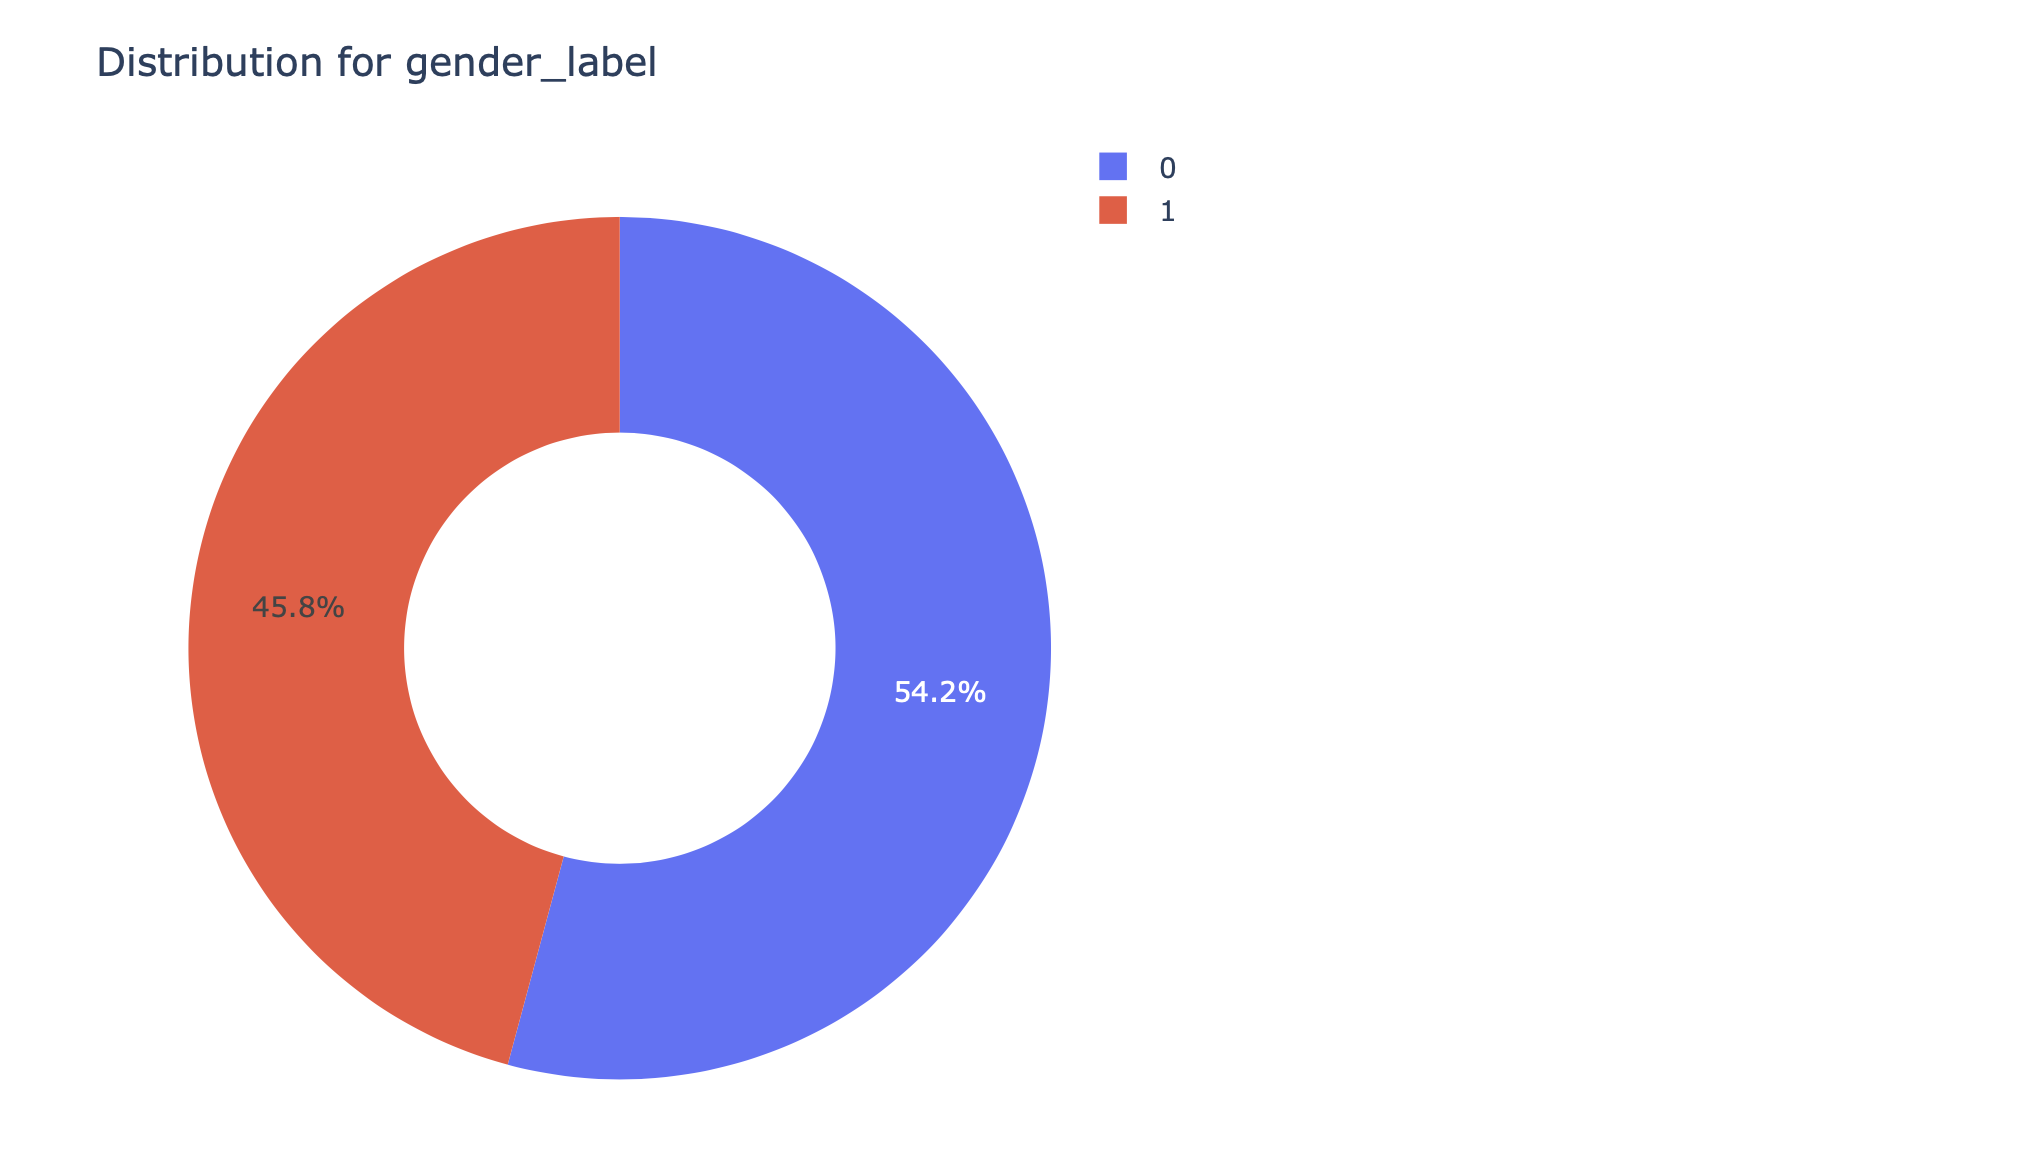

In [587]:
plot_distribution(train_dataset['age_group'])

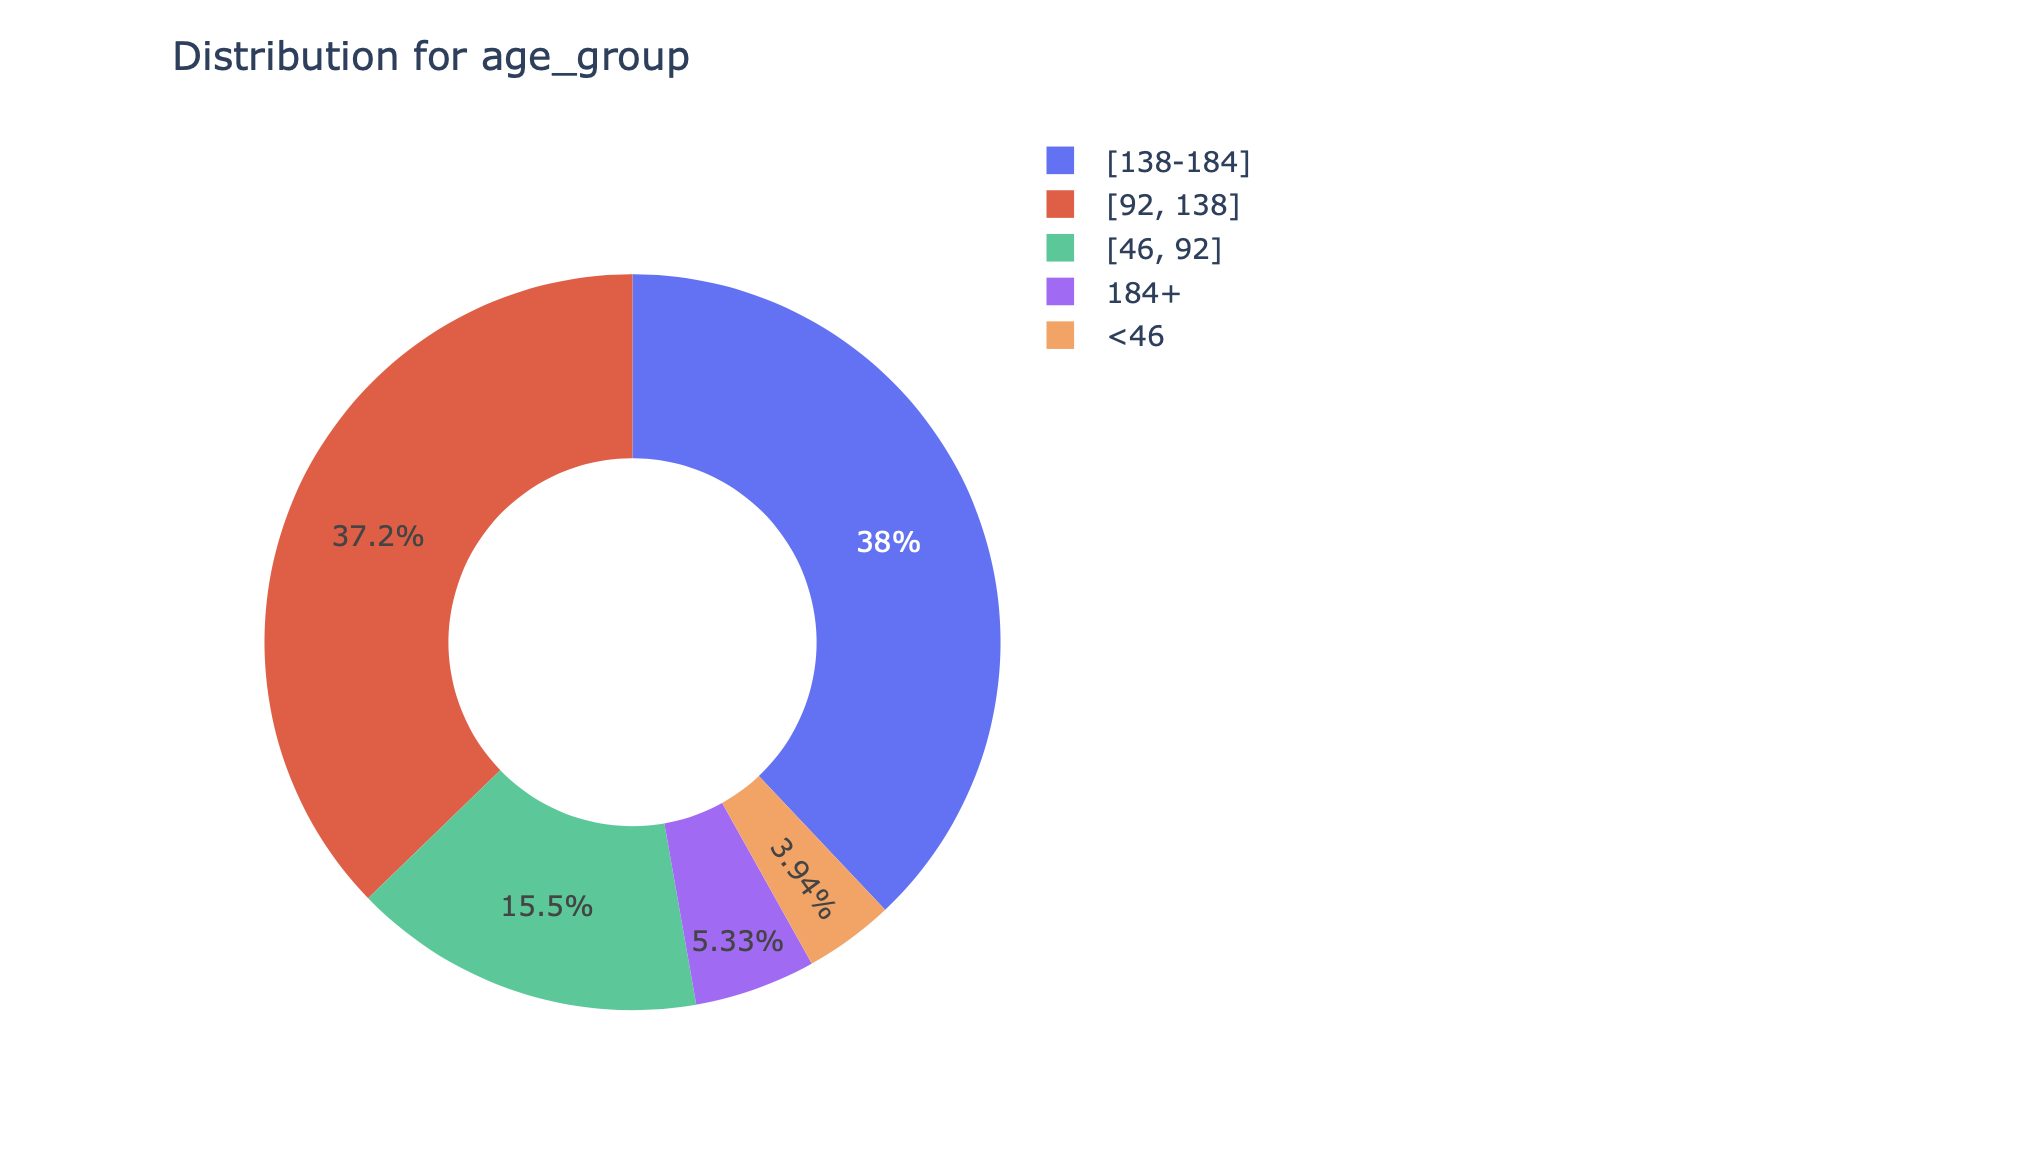

In [109]:
def plot_age_distribution(data,bins=20, string='before sampling'):
    
    fig = px.histogram(data, x="boneage", nbins=bins)
    fig.update_layout(title_text='Boneage distribution '+string, width=1000,height=700)
    fig.show()

In [588]:
plot_age_distribution(train_dataset)

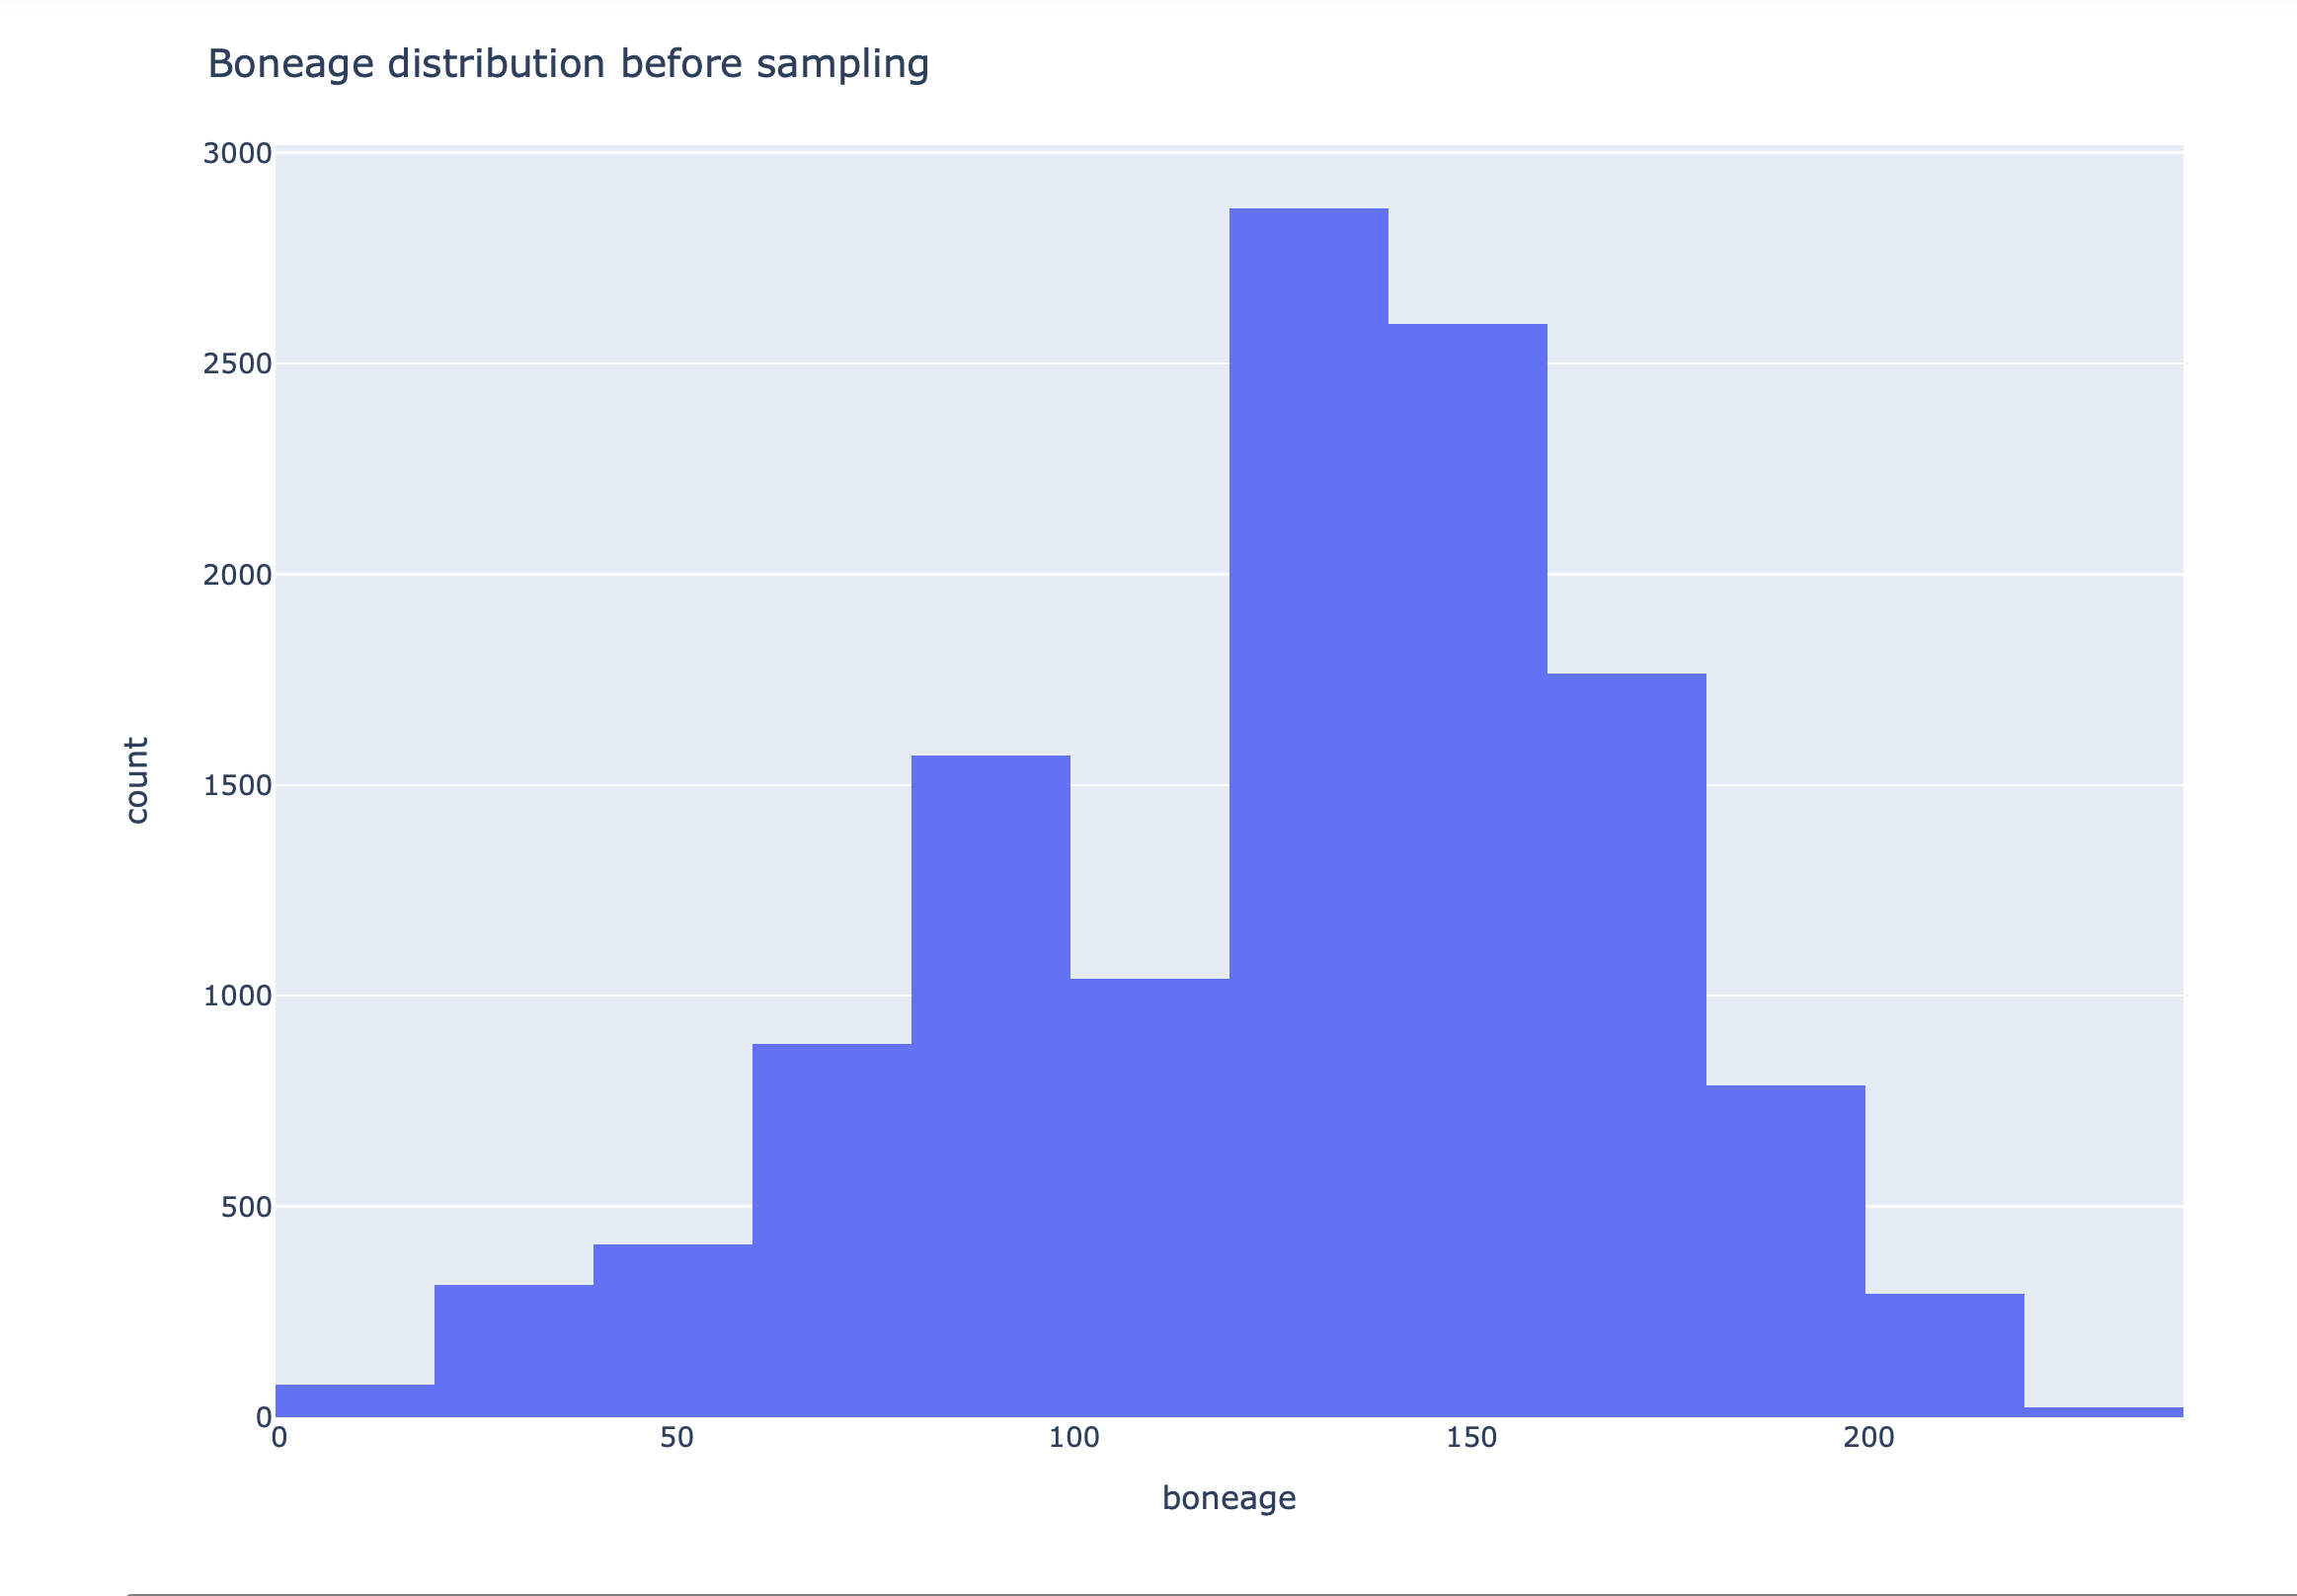

### Data Augumentation

In [111]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

### resharp data 

In [529]:
def reshape_data(data):
    
    n, h, w, c = data.shape
    
    return data.reshape((n, h*w*c))

In [530]:
train_df = reshape_data(train_images_norm)
val_df = reshape_data(val_images_norm)

In [112]:
oversample = SMOTE()

In [113]:
y =  train_dataset.iloc[:, -1]
labels = LabelEncoder().fit_transform(y)
X1 = train_dataset[['boneage', 'gender_label']]
X1, label = oversample.fit_resample(X1, labels)

In [36]:
xval = val_dataset[['boneage', 'gender_label']]
yval = val_dataset.iloc[:, -1]
ylabel = LabelEncoder().fit_transform(yval)
xval, ylabels = oversample.fit_resample(xval, ylabel)

In [37]:
aug_images, y = oversample.fit_resample(train_df, labels)

In [38]:
val_aug_images, lab = oversample.fit_resample(val_df,ylabel)

In [39]:
labs = pd.DataFrame(label, columns =['lab'])

In [589]:
plot_distribution(labs['lab'])

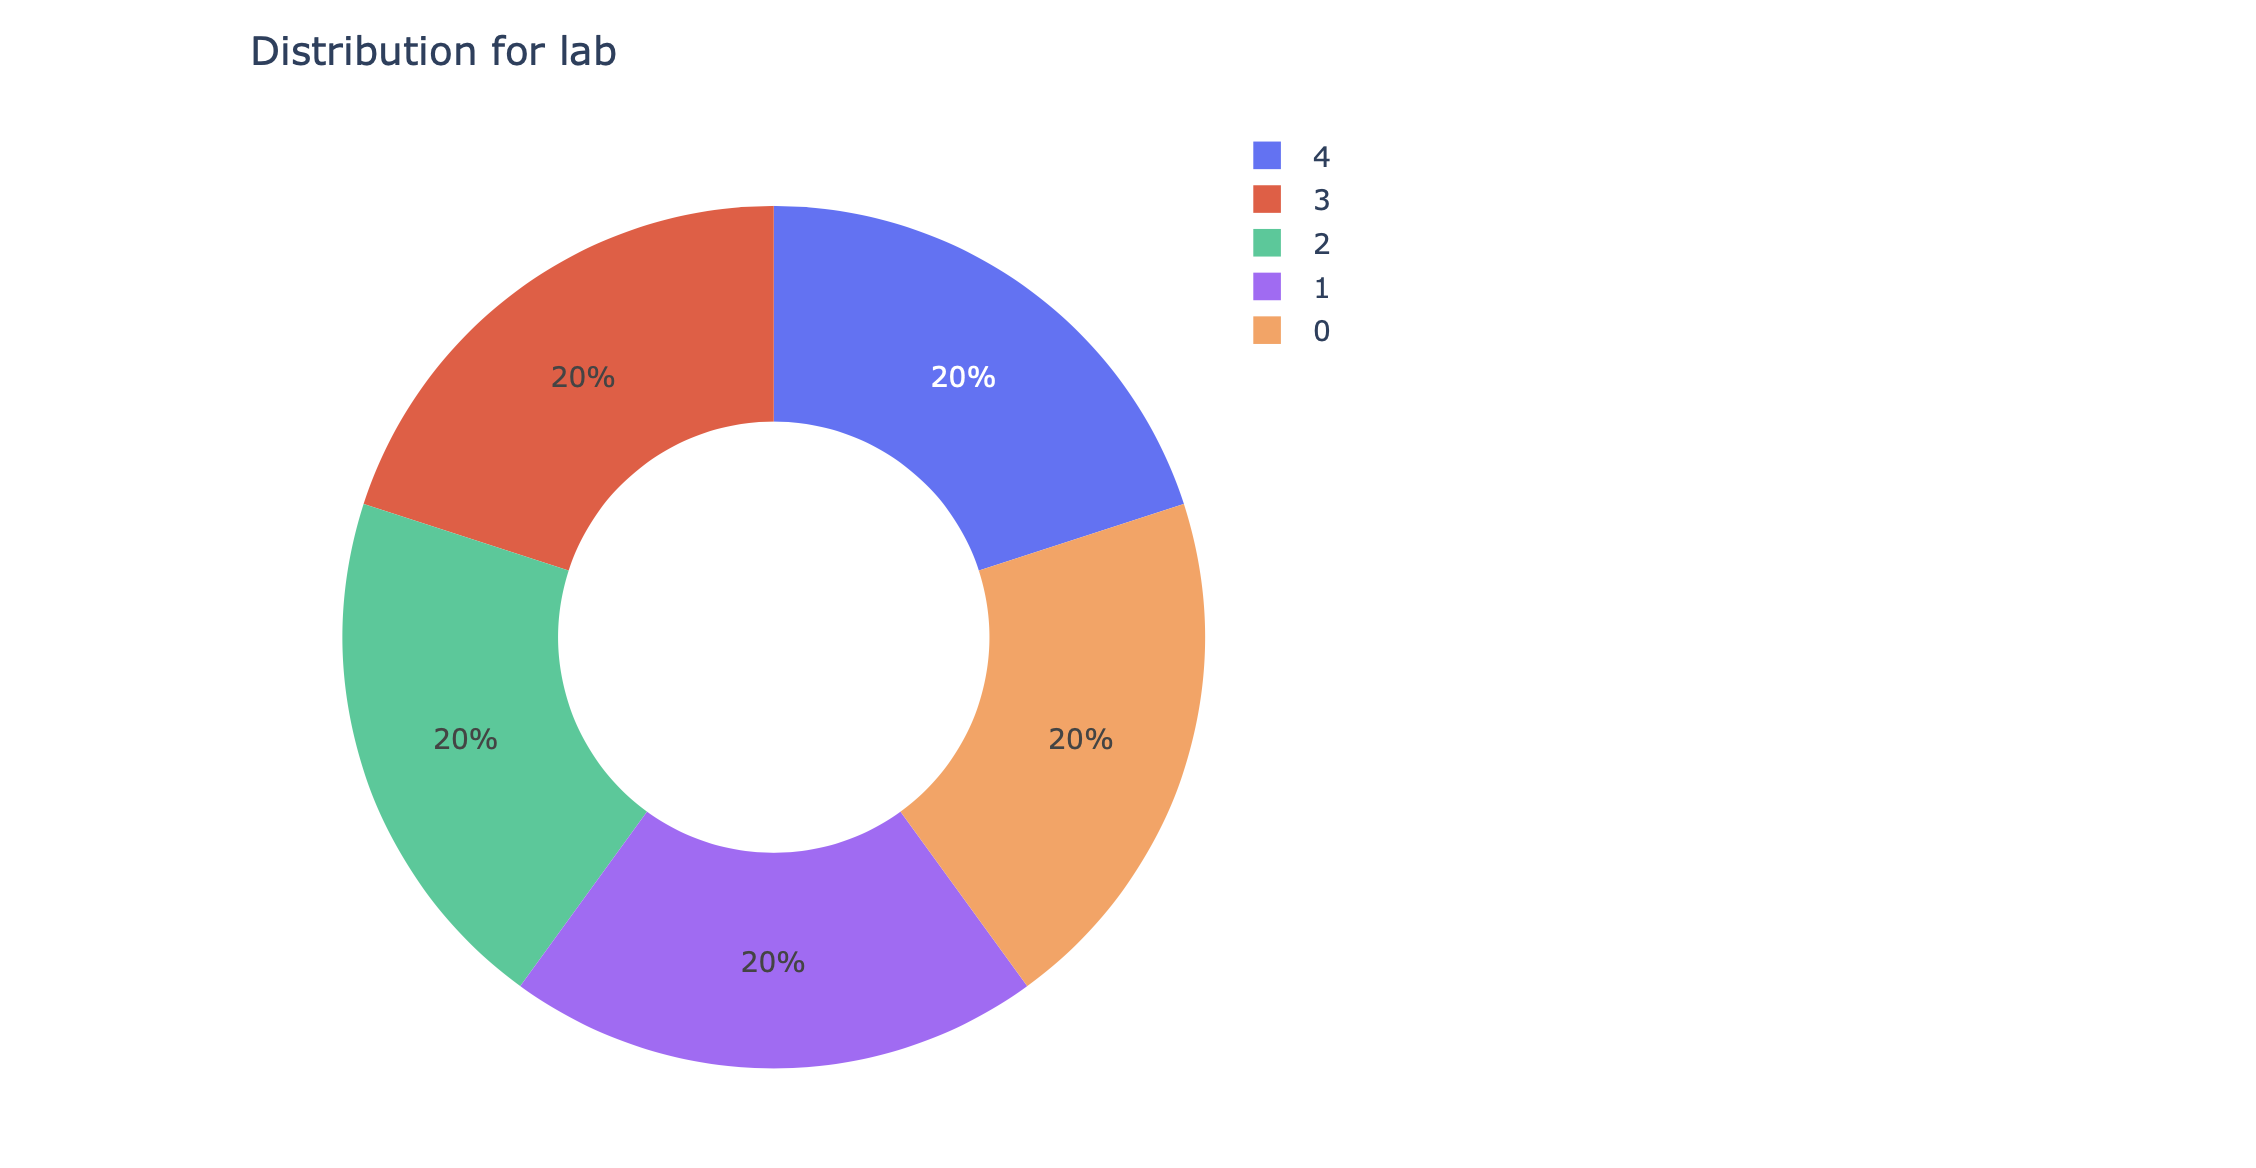

In [590]:
plot_distribution(X1['gender_label'])

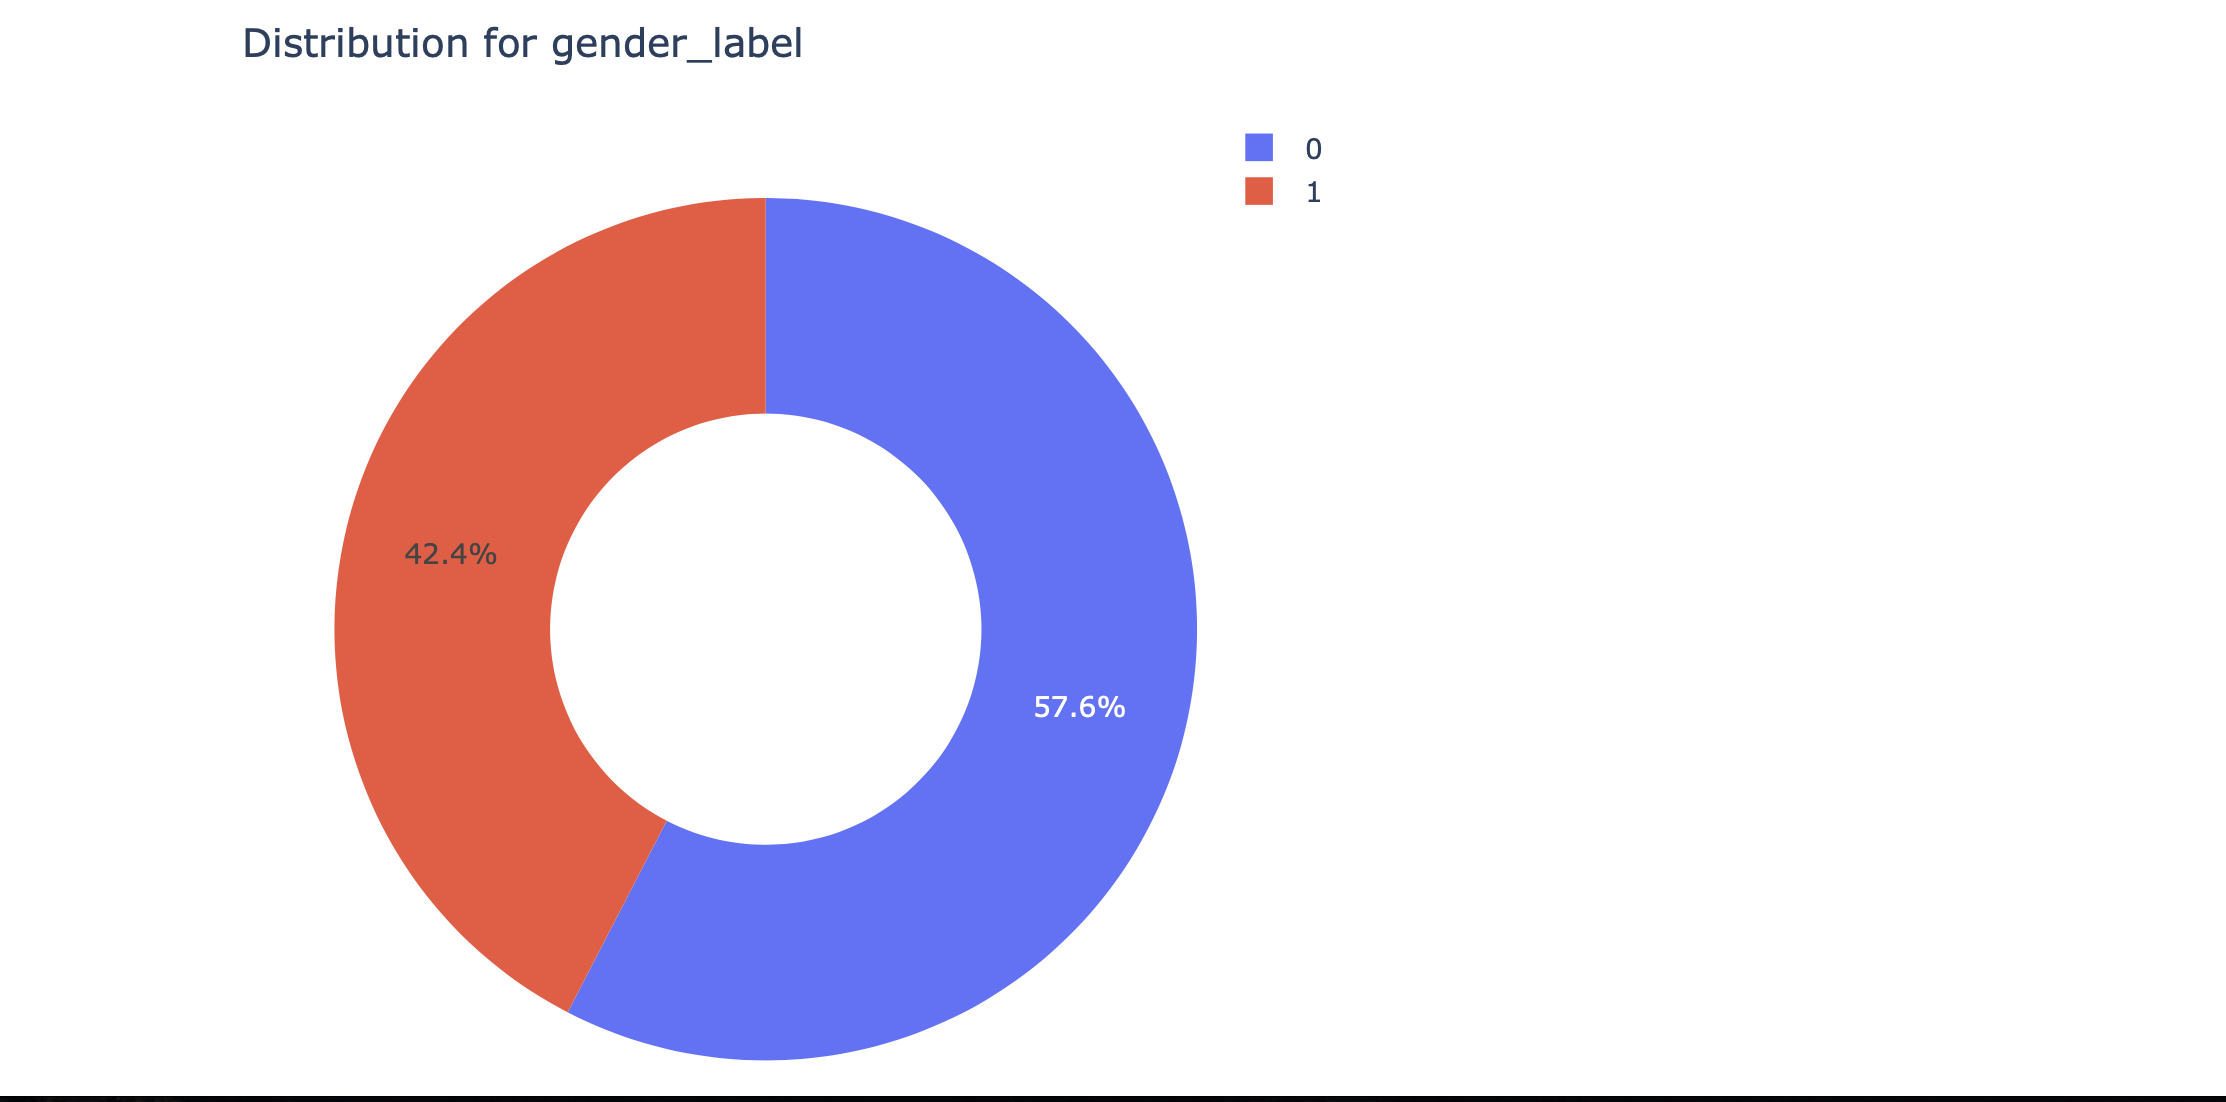

In [591]:
plot_age_distribution(X1, string='after sampling', bins=10)

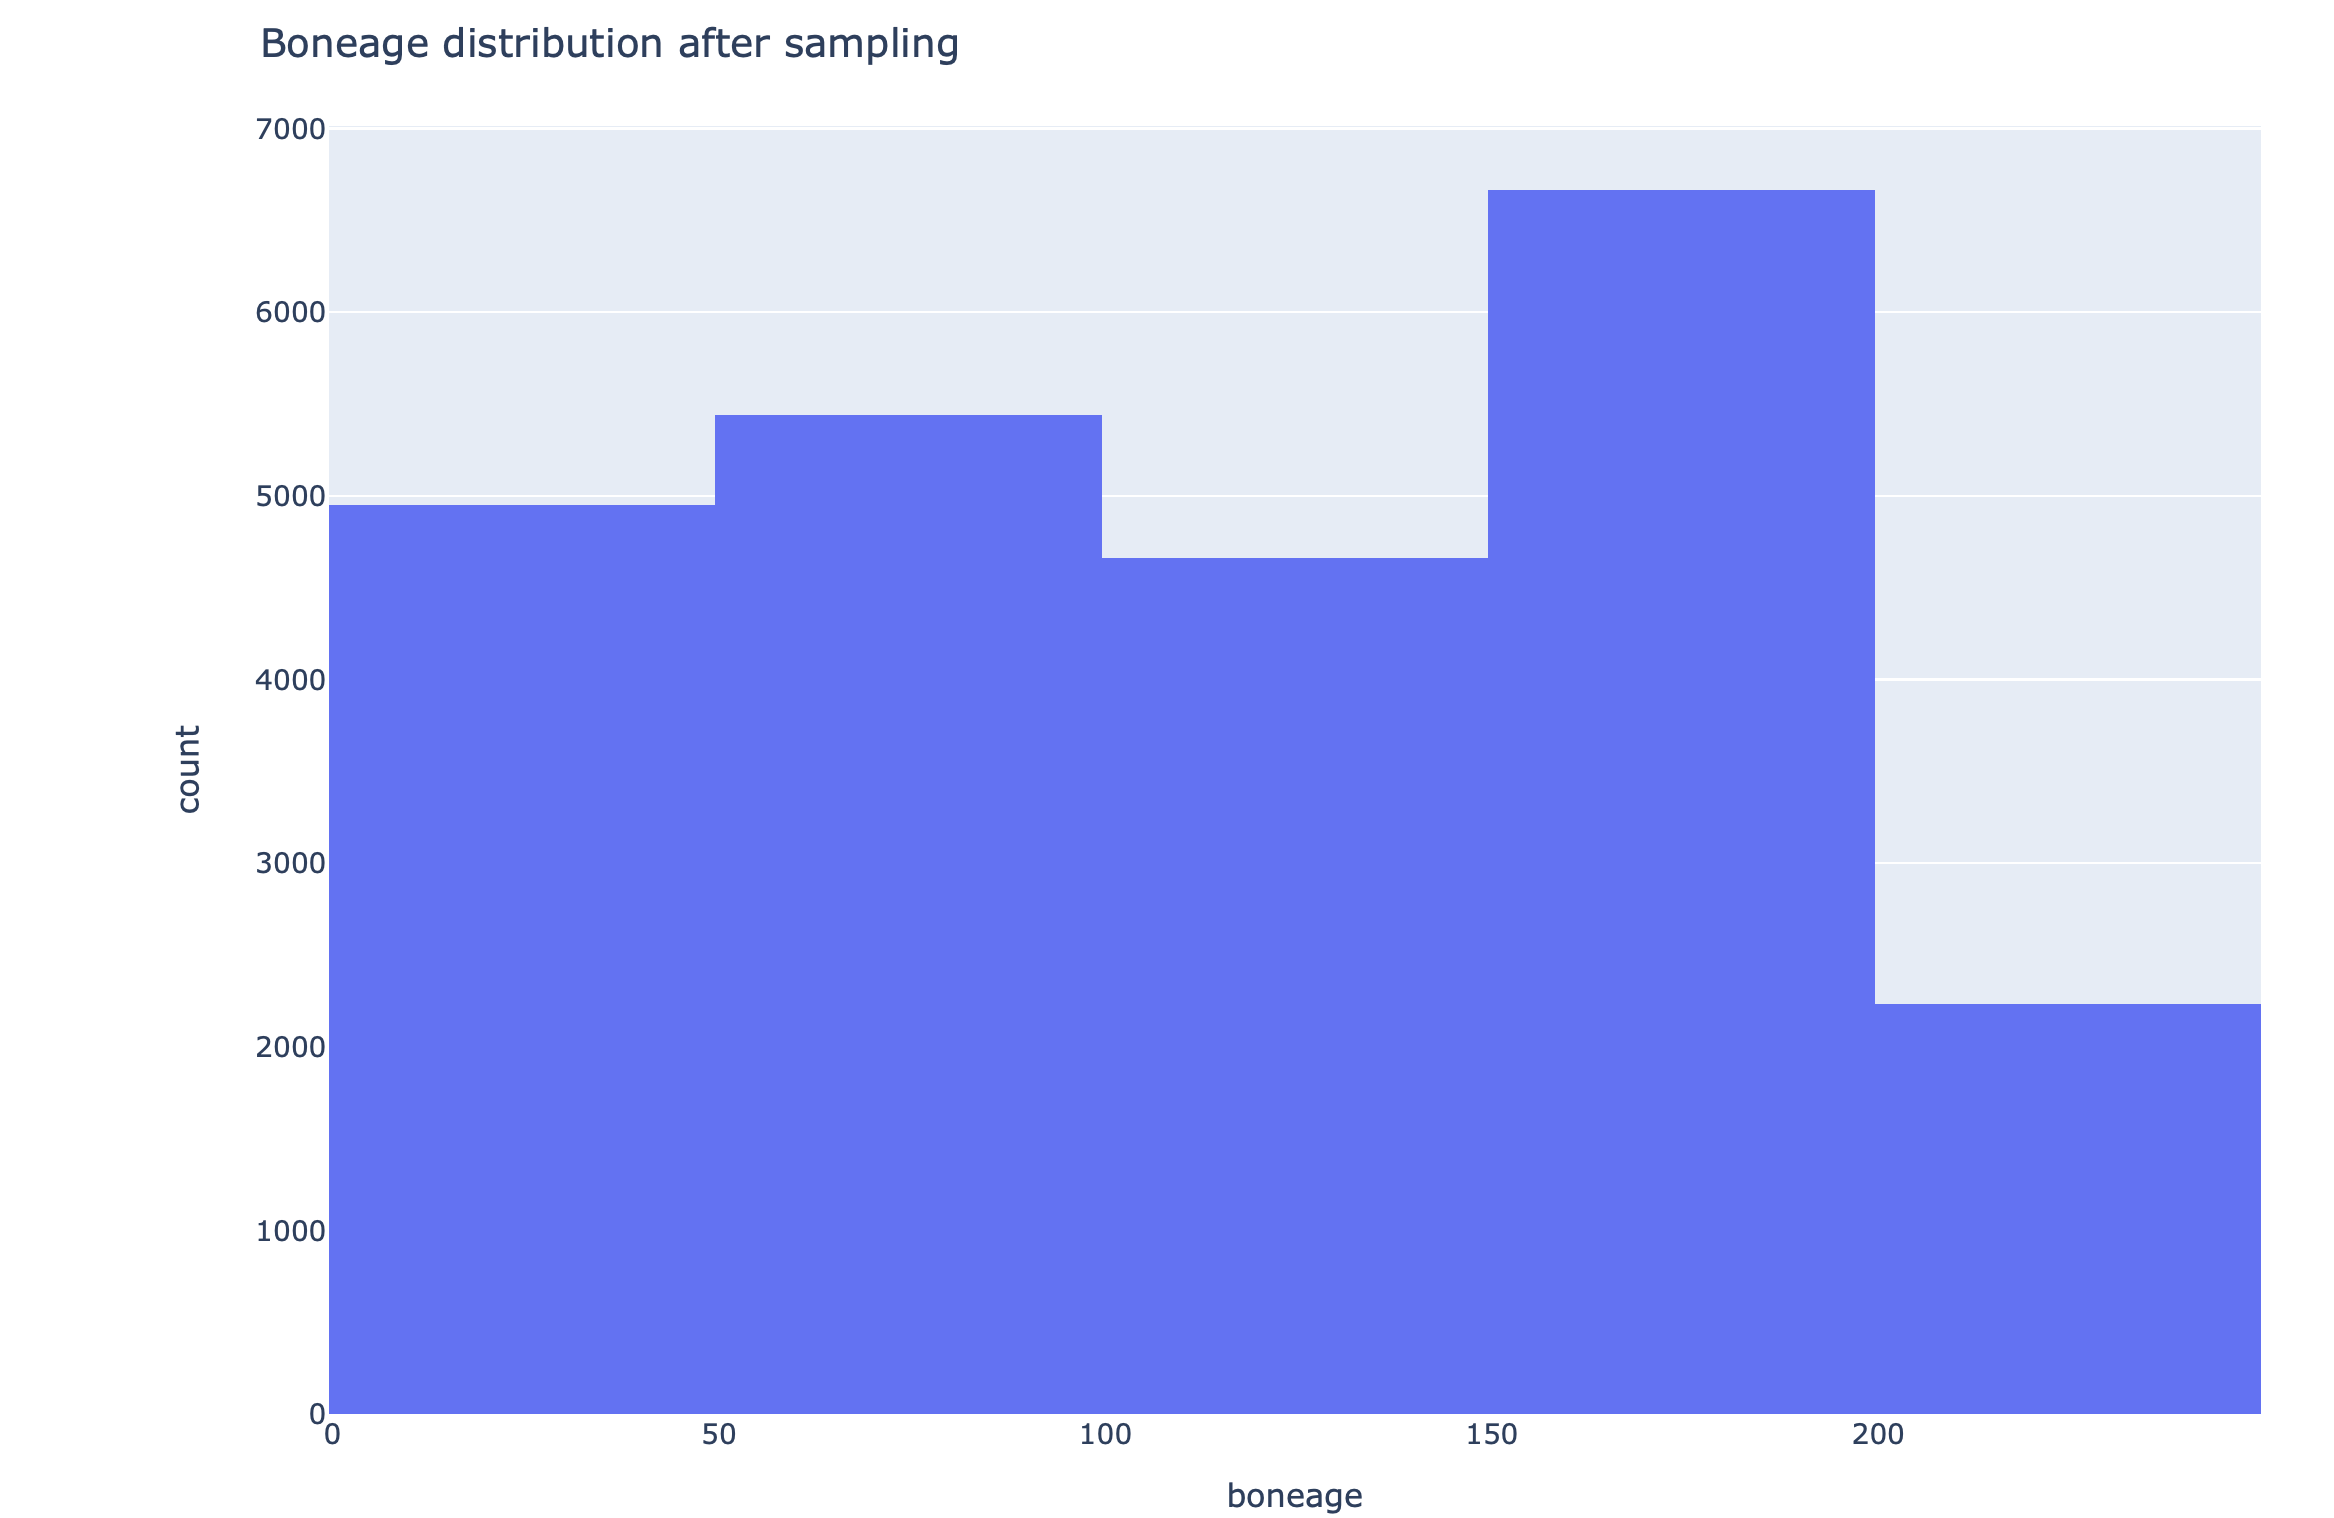

# Random Forest 

In [487]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, auc
from  sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from subprocess import call
import itertools

In [488]:
x1 = X1.to_numpy() # convert to numpy for the train set
x = xval.to_numpy() # convert to numpy for the validation set

In [489]:
xtrain = aug_images   
xtest =  val_aug_images

In [490]:
ytrain = get_age_gen_labels(x1[:, 0],label, x1[:, 1])
ytest  = get_age_gen_labels(x[:, 0],ylabels, x[:, 1])

## Build the forest

In [565]:
def build_random_forest_classifier(xtrain,xtest,ytrain,ytest, n_trees, depth):
    
    # random forest models creation
    rfc_age = RandomForestClassifier(n_estimators=n_trees,bootstrap=True, min_samples_split=100,  ## create n trees
                             max_features='sqrt',random_state=10, min_samples_leaf=40,
                                     max_depth=depth, n_jobs=-1, verbose=0)
    
    rfc_sex = RandomForestClassifier(n_estimators=n_trees,bootstrap=True, min_samples_split=5,  ## create n trees
                                     max_features='sqrt',random_state=10, min_samples_leaf=5,
                                     max_depth=depth, n_jobs=-1, verbose=0)
    
    rfc_age.fit(xtrain,ytrain[:, 1])
    rfc_sex.fit(xtrain,ytrain[:, 2])
    
    return [rfc_age, rfc_sex]


In [566]:
rfc = build_random_forest_classifier(xtrain,xtest,ytrain,ytest, 500, 20)

### predict and report results

In [567]:
def predict_and_report(rfc):
    
    rfc_predict_age = rfc[0].predict(xtest) # age_group predictions 
    rfc_predict_sex = rfc[1].predict(xtest) # sex predictions
    
    print(colored("\n\n Classification Report Age group\n\n", 'red'), classification_report(ytest[:,1], rfc_predict_age))
    print(colored("\n\n Classification Report Sex\n\n", 'green'), classification_report(ytest[:,2], rfc_predict_sex))
    
    return [rfc_predict_age, rfc_predict_sex]


In [568]:
predictions = predict_and_report(rfc)



 Classification Report Age group

               precision    recall  f1-score   support

           0       0.66      0.74      0.69       540
           1       0.46      0.53      0.49       540
           2       0.35      0.29      0.32       540
           3       0.43      0.46      0.45       540
           4       0.61      0.51      0.56       540

    accuracy                           0.51      2700
   macro avg       0.50      0.51      0.50      2700
weighted avg       0.50      0.51      0.50      2700



 Classification Report Sex

               precision    recall  f1-score   support

           0       0.63      0.82      0.71      1628
           1       0.49      0.27      0.35      1072

    accuracy                           0.60      2700
   macro avg       0.56      0.54      0.53      2700
weighted avg       0.58      0.60      0.57      2700



In [581]:
def compute_roc_values(rfc):

    roc_value_age = roc_auc_score(ytest[:,1],rfc[0].predict_proba(xtest)[:,0:], 
                              labels=[0, 1, 2, 3, 4],multi_class='ovr')
    roc_value_sex = roc_auc_score(ytest[:,2], rfc[1].predict_proba(xtest)[:,1])
    
    print(f'Roc values [Age:{roc_value_age},Sex:{roc_value_sex}]')

In [582]:
compute_roc_values(rfc)

Roc values [Age:0.8076394032921812,Sex:0.6126576882173898]


### Check perfomance

#### plot confusion matrix

In [632]:
def plot_confusion_matrix(cm, classes,title=''):
   

    plt.figure(figsize = (10, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title(title, size = 20)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 10, fontsize=14)
    plt.yticks(tick_marks, classes, size = 10, fontsize=14)

    fmt = '.2%' #if False else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

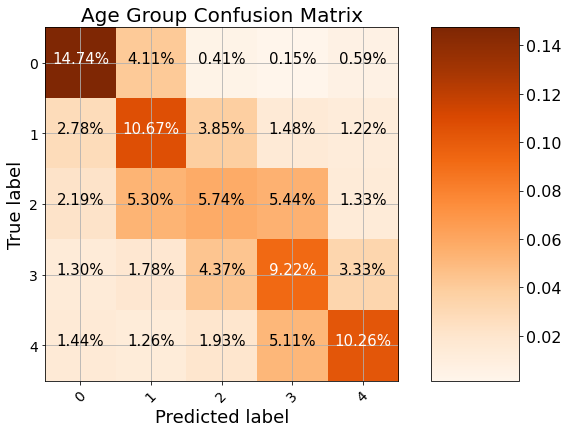

In [633]:
# age_group
cm_age = confusion_matrix(ytest[:,1], predictions[0])
plot_confusion_matrix(cm_age/np.sum(cm_age), classes = ['0', '1','2', '3', '4'],
                  title = 'Age Group Confusion Matrix')

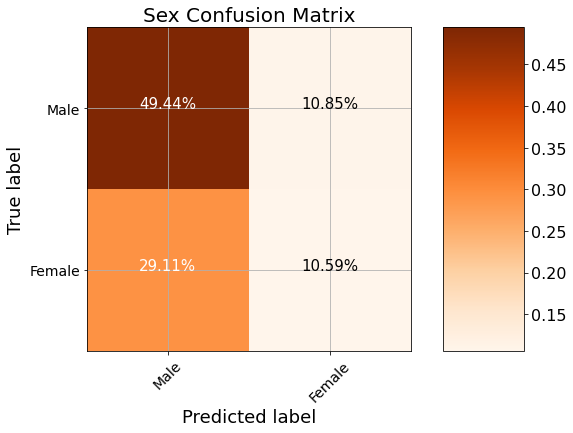

In [634]:
# Plot conf matrix for sex
cm_sex = confusion_matrix(ytest[:,2], predictions[1])
plot_confusion_matrix(cm_sex/np.sum(cm_sex), classes = ['Male', 'Female'],
                      title = 'Sex Confusion Matrix')

#### plot roc_curve

In [574]:
def plot_roc_curve(rfc):
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(ytest[:,2], [1 for _ in range(len(ytest))])
    model_fpr, model_tpr, _ = roc_curve(ytest[:,2], rfc[1].predict_proba(xtest)[:,1])
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    #Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', linestyle=':',linewidth = 4, label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.show()

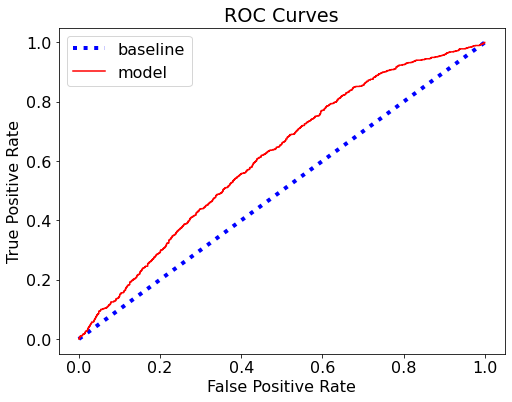

In [575]:
 plot_roc_curve(rfc)

####  Show trees

In [576]:
def export_trees(rfc):
    
    # Export a tree from the forest
    export_graphviz(rfc[0].estimators_[1], 'age_group_tree_from_optimized_forest.dot', # age group tree
                    rounded = True, max_depth = 4, 
                    class_names = ['0', '1','2', '3', '4'], filled = True)
    
    export_graphviz(rfc[1].estimators_[1], 'sex_tree_from_optimized_forest.dot',  ## sex tree 
                    rounded = True, max_depth = 4, 
                    class_names = ['Male', 'Female'], filled = True) 

In [577]:
get_trees = export_trees(rfc)

In [578]:
call(['dot', '-Tpng', 'sex_tree_from_optimized_forest.dot', '-o', 'sex_tree.png', '-Gdpi=300'])

0

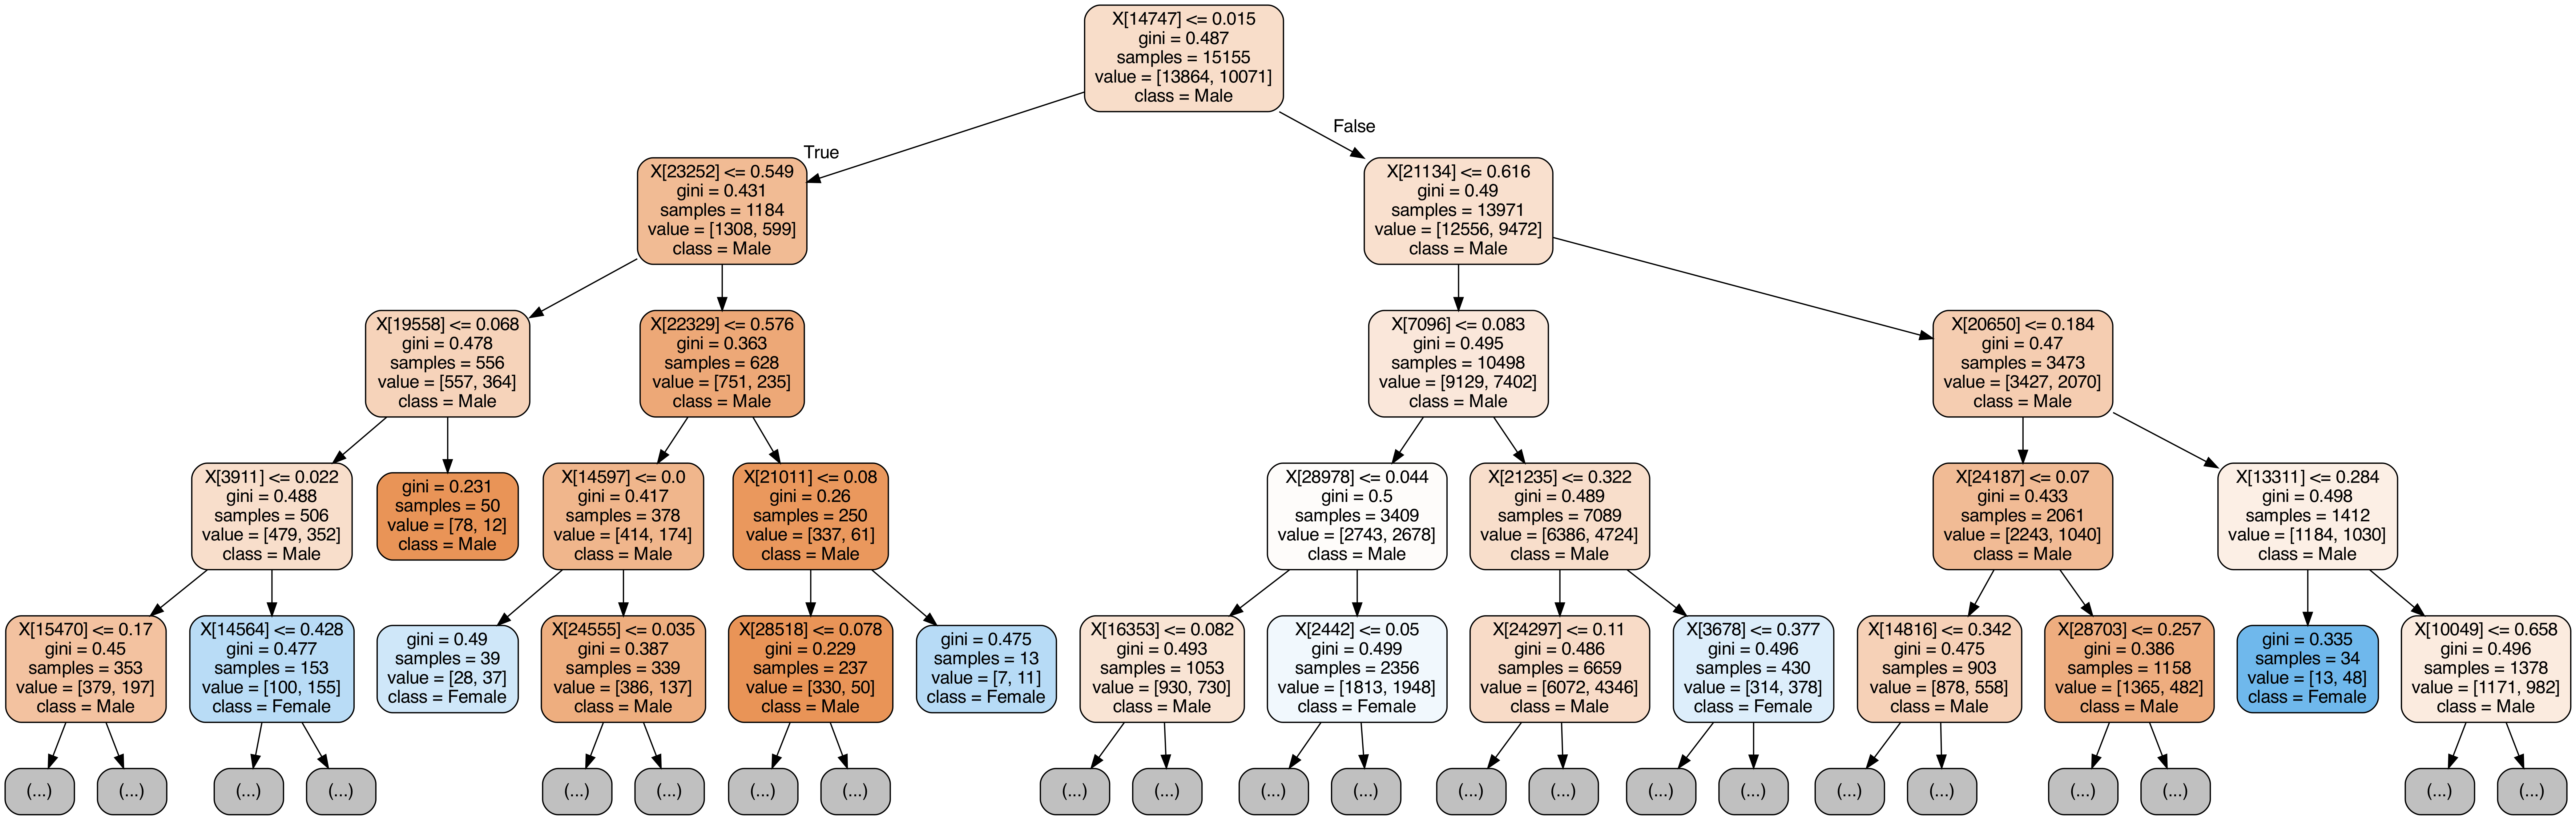

In [515]:
from IPython.display import Image
Image('sex_tree.png')

In [516]:
call(['dot', '-Tpng', 'age_group_tree_from_optimized_forest.dot', '-o', 'age_tree.png', '-Gdpi=300'])

0

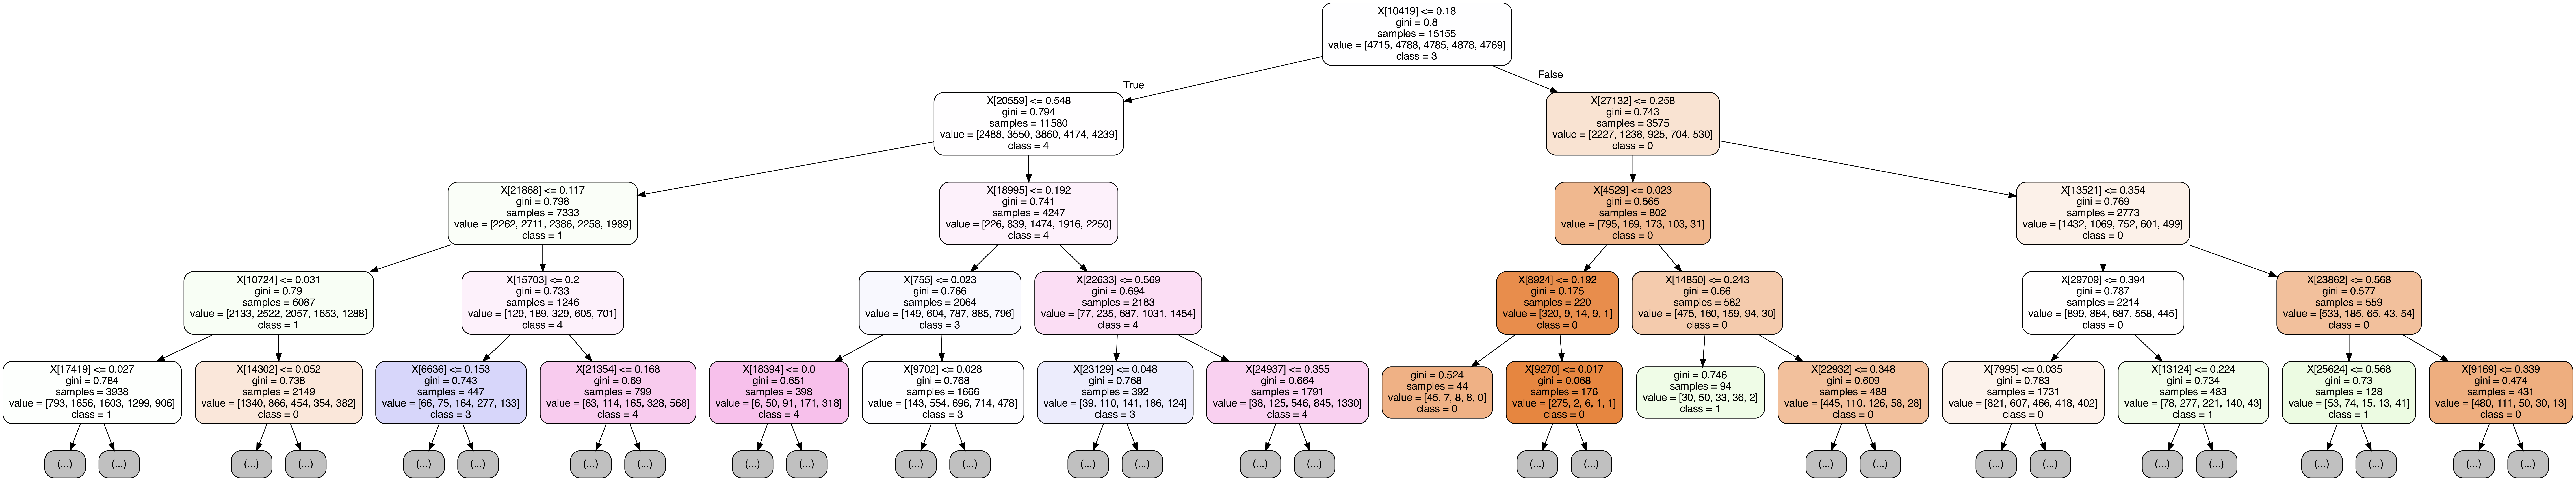

In [517]:
Image('age_tree.png')

# CNN

In [130]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Flatten, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import  Model
import tensorflow as tf

In [131]:
train_labls = get_age_gen_labels(x1[:, 0],label, x1[:, 1])
val_labls = get_age_gen_labels(x[:, 0],ylabels, x[:, 1])


In [132]:
train_aug_images = aug_images.reshape(23935, 100, 100, 3)
test_aug_images =  val_aug_images.reshape(2700, 100, 100, 3)

#### split_train_data

In [133]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train_aug_images, train_labls, test_size=0.2)

#### one_hot_encoding

In [134]:
one_hot_group_tr = to_categorical(Ytrain[:,1])
one_hot_group_va = to_categorical(Ytest[:, 1])
one_hot_test     = to_categorical(val_labls[:,1])

In [135]:
train = [Ytrain[:,0], one_hot_group_tr, Ytrain[:,2]]
validation = [Ytest[:,0],one_hot_group_va,Ytest[:,2]]
test  = [val_labls[:,0],one_hot_test,val_labls[:,2]]

### Buld CNN

In [136]:
class BoneAgeModel():
    """
    This class contains three branches [age, age_group, sex]
    Each branch contains a sequence of Convolutional Layers defined
    on the block_layers method
    """

    def global_block_layers(self,inputs):
        """
        Generate a default set of hidden layers whose structure is defined as:
        Conv2D -> Pooling -> Dropout
        """
        
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.1)(x)
        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        x = Conv2D(32, (3, 3), padding="same")(x) 
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        return x
    
    def age_group_branch(self,inputs):
        """
        Build age_group branch of the model with configuration:
        Conv  -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.global_block_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = Dropout(0.5)(x)
        x = Dense(5)(x) #  num_age_groups
        x = Activation("softmax", name="age_group_output")(x)
        
        return x
    
    def sex_branch(self, inputs):
        """
        Build sex branch of the model with configuration:
        Conv -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.global_block_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("sigmoid", name="sex_output")(x)
        
        return x
    
    def age_branch(self,inputs):
        """
        Build sex branch of the model with configuration:
        Conv -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.global_block_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="boneage_output")(x)
        
        return x
    
    def model_branches(self,input_shape):

        inputs = Input(input_shape)
        age_branch = self.age_branch(inputs)
        age_group_branch = self.age_group_branch(inputs)
        sex_branch = self.sex_branch(inputs)

        model = Model(inputs=inputs, name="xray_boneage",
                      outputs=[age_branch,age_group_branch,sex_branch])

        return model

### define the model

In [137]:
model = BoneAgeModel().model_branches(train_images[0].shape)

In [585]:
model.summary()

Model: "xray_boneage"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 100, 100, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 100, 100, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 100, 100, 16) 448         input_3[0][0]                    
_______________________________________________________________________________________

### define the model

In [138]:
model.compile(optimizer=Adam(lr=1e-4),
              loss={'boneage_output':'mse','age_group_output': 'categorical_crossentropy', 
                    'sex_output': 'binary_crossentropy'},
              metrics={'boneage_output': 'mae','age_group_output': 'accuracy',
                       'sex_output': 'accuracy'})

In [139]:
age_gender = 'age_gender_classification.h5'

checkpoint = ModelCheckpoint(age_gender, monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=False,
                            mode='auto', save_freq='epoch')

early_stop = EarlyStopping(patience=75, monitor='val_loss', 
                           restore_best_weights=True)

In [140]:
call_back_list = [checkpoint, early_stop]

In [141]:
model_history = model.fit(Xtrain, train, batch_size=64, 
                    validation_data=(Xtest, validation), epochs=300, 
                    callbacks=[call_back_list])

Epoch 1/300
300/300 [==============================] - ETA: 0s - loss: 7009.3032 - boneage_output_loss: 7007.0381 - age_group_output_loss: 1.5826 - sex_output_loss: 0.6846 - boneage_output_mae: 68.0267 - age_group_output_accuracy: 0.2506 - sex_output_accuracy: 0.5715
Epoch 00001: val_loss improved from inf to 4885.51660, saving model to age_gender_classification.h5
300/300 [==============================] - 112s 375ms/step - loss: 7009.3032 - boneage_output_loss: 7007.0381 - age_group_output_loss: 1.5826 - sex_output_loss: 0.6846 - boneage_output_mae: 68.0267 - age_group_output_accuracy: 0.2506 - sex_output_accuracy: 0.5715 - val_loss: 4885.5166 - val_boneage_output_loss: 4883.2871 - val_age_group_output_loss: 1.5430 - val_sex_output_loss: 0.6856 - val_boneage_output_mae: 57.2645 - val_age_group_output_accuracy: 0.3255 - val_sex_output_accuracy: 0.5693
Epoch 2/300
300/300 [==============================] - ETA: 0s - loss: 3915.4836 - boneage_output_loss: 3913.2959 - age_group_output_lo

Epoch 11/300
300/300 [==============================] - ETA: 0s - loss: 3191.2654 - boneage_output_loss: 3189.4822 - age_group_output_loss: 1.1161 - sex_output_loss: 0.6677 - boneage_output_mae: 46.6483 - age_group_output_accuracy: 0.5241 - sex_output_accuracy: 0.5864
Epoch 00011: val_loss improved from 4067.59106 to 3846.62329, saving model to age_gender_classification.h5
300/300 [==============================] - 100s 335ms/step - loss: 3191.2654 - boneage_output_loss: 3189.4822 - age_group_output_loss: 1.1161 - sex_output_loss: 0.6677 - boneage_output_mae: 46.6483 - age_group_output_accuracy: 0.5241 - sex_output_accuracy: 0.5864 - val_loss: 3846.6233 - val_boneage_output_loss: 3844.8762 - val_age_group_output_loss: 1.0760 - val_sex_output_loss: 0.6706 - val_boneage_output_mae: 49.6723 - val_age_group_output_accuracy: 0.5561 - val_sex_output_accuracy: 0.5824
Epoch 12/300
300/300 [==============================] - ETA: 0s - loss: 3175.6172 - boneage_output_loss: 3173.8503 - age_group_

Epoch 21/300
300/300 [==============================] - ETA: 0s - loss: 2952.3552 - boneage_output_loss: 2950.6948 - age_group_output_loss: 1.0033 - sex_output_loss: 0.6581 - boneage_output_mae: 44.5614 - age_group_output_accuracy: 0.5761 - sex_output_accuracy: 0.5932
Epoch 00021: val_loss did not improve from 3846.62329
300/300 [==============================] - 95s 316ms/step - loss: 2952.3552 - boneage_output_loss: 2950.6948 - age_group_output_loss: 1.0033 - sex_output_loss: 0.6581 - boneage_output_mae: 44.5614 - age_group_output_accuracy: 0.5761 - sex_output_accuracy: 0.5932 - val_loss: 3997.3186 - val_boneage_output_loss: 3995.6897 - val_age_group_output_loss: 0.9639 - val_sex_output_loss: 0.6647 - val_boneage_output_mae: 49.9546 - val_age_group_output_accuracy: 0.6020 - val_sex_output_accuracy: 0.5876
Epoch 22/300
300/300 [==============================] - ETA: 0s - loss: 2939.2244 - boneage_output_loss: 2937.5752 - age_group_output_loss: 0.9911 - sex_output_loss: 0.6575 - boneag

Epoch 31/300
300/300 [==============================] - ETA: 0s - loss: 2762.4712 - boneage_output_loss: 2760.8982 - age_group_output_loss: 0.9196 - sex_output_loss: 0.6519 - boneage_output_mae: 42.8623 - age_group_output_accuracy: 0.6136 - sex_output_accuracy: 0.6017
Epoch 00031: val_loss did not improve from 3576.21802
300/300 [==============================] - 95s 317ms/step - loss: 2762.4712 - boneage_output_loss: 2760.8982 - age_group_output_loss: 0.9196 - sex_output_loss: 0.6519 - boneage_output_mae: 42.8623 - age_group_output_accuracy: 0.6136 - sex_output_accuracy: 0.6017 - val_loss: 4051.6833 - val_boneage_output_loss: 4050.1426 - val_age_group_output_loss: 0.8812 - val_sex_output_loss: 0.6594 - val_boneage_output_mae: 50.4525 - val_age_group_output_accuracy: 0.6434 - val_sex_output_accuracy: 0.5899
Epoch 32/300
300/300 [==============================] - ETA: 0s - loss: 2744.4197 - boneage_output_loss: 2742.8533 - age_group_output_loss: 0.9164 - sex_output_loss: 0.6512 - boneag

Epoch 41/300
300/300 [==============================] - ETA: 0s - loss: 2520.3279 - boneage_output_loss: 2518.8293 - age_group_output_loss: 0.8543 - sex_output_loss: 0.6450 - boneage_output_mae: 40.6234 - age_group_output_accuracy: 0.6419 - sex_output_accuracy: 0.6167
Epoch 00041: val_loss did not improve from 3077.49585
300/300 [==============================] - 95s 316ms/step - loss: 2520.3279 - boneage_output_loss: 2518.8293 - age_group_output_loss: 0.8543 - sex_output_loss: 0.6450 - boneage_output_mae: 40.6234 - age_group_output_accuracy: 0.6419 - sex_output_accuracy: 0.6167 - val_loss: 3536.1450 - val_boneage_output_loss: 3534.6848 - val_age_group_output_loss: 0.8057 - val_sex_output_loss: 0.6547 - val_boneage_output_mae: 47.2908 - val_age_group_output_accuracy: 0.6747 - val_sex_output_accuracy: 0.5908
Epoch 42/300
300/300 [==============================] - ETA: 0s - loss: 2507.3779 - boneage_output_loss: 2505.8877 - age_group_output_loss: 0.8472 - sex_output_loss: 0.6444 - boneag

Epoch 51/300
300/300 [==============================] - ETA: 0s - loss: 2319.5771 - boneage_output_loss: 2318.1331 - age_group_output_loss: 0.8058 - sex_output_loss: 0.6398 - boneage_output_mae: 38.6469 - age_group_output_accuracy: 0.6635 - sex_output_accuracy: 0.6246
Epoch 00051: val_loss did not improve from 2827.71094
300/300 [==============================] - 95s 315ms/step - loss: 2319.5771 - boneage_output_loss: 2318.1331 - age_group_output_loss: 0.8058 - sex_output_loss: 0.6398 - boneage_output_mae: 38.6469 - age_group_output_accuracy: 0.6635 - sex_output_accuracy: 0.6246 - val_loss: 3146.6680 - val_boneage_output_loss: 3145.2539 - val_age_group_output_loss: 0.7623 - val_sex_output_loss: 0.6511 - val_boneage_output_mae: 44.3282 - val_age_group_output_accuracy: 0.6950 - val_sex_output_accuracy: 0.6033
Epoch 52/300
300/300 [==============================] - ETA: 0s - loss: 2294.1802 - boneage_output_loss: 2292.7463 - age_group_output_loss: 0.7974 - sex_output_loss: 0.6354 - boneag

Epoch 61/300
300/300 [==============================] - ETA: 0s - loss: 2166.9282 - boneage_output_loss: 2165.5339 - age_group_output_loss: 0.7581 - sex_output_loss: 0.6349 - boneage_output_mae: 37.1842 - age_group_output_accuracy: 0.6747 - sex_output_accuracy: 0.6271
Epoch 00061: val_loss did not improve from 2601.98267
300/300 [==============================] - 95s 316ms/step - loss: 2166.9282 - boneage_output_loss: 2165.5339 - age_group_output_loss: 0.7581 - sex_output_loss: 0.6349 - boneage_output_mae: 37.1842 - age_group_output_accuracy: 0.6747 - sex_output_accuracy: 0.6271 - val_loss: 2847.5100 - val_boneage_output_loss: 2846.1555 - val_age_group_output_loss: 0.7079 - val_sex_output_loss: 0.6463 - val_boneage_output_mae: 42.1536 - val_age_group_output_accuracy: 0.7172 - val_sex_output_accuracy: 0.6073
Epoch 62/300
300/300 [==============================] - ETA: 0s - loss: 2149.2576 - boneage_output_loss: 2147.8755 - age_group_output_loss: 0.7511 - sex_output_loss: 0.6317 - boneag

Epoch 71/300
300/300 [==============================] - ETA: 0s - loss: 2064.8735 - boneage_output_loss: 2063.5276 - age_group_output_loss: 0.7216 - sex_output_loss: 0.6245 - boneage_output_mae: 36.1381 - age_group_output_accuracy: 0.6956 - sex_output_accuracy: 0.6362
Epoch 00071: val_loss did not improve from 2422.67090
300/300 [==============================] - 93s 311ms/step - loss: 2064.8735 - boneage_output_loss: 2063.5276 - age_group_output_loss: 0.7216 - sex_output_loss: 0.6245 - boneage_output_mae: 36.1381 - age_group_output_accuracy: 0.6956 - sex_output_accuracy: 0.6362 - val_loss: 2809.8140 - val_boneage_output_loss: 2808.5103 - val_age_group_output_loss: 0.6593 - val_sex_output_loss: 0.6447 - val_boneage_output_mae: 41.9414 - val_age_group_output_accuracy: 0.7332 - val_sex_output_accuracy: 0.6035
Epoch 72/300
300/300 [==============================] - ETA: 0s - loss: 2059.0815 - boneage_output_loss: 2057.7400 - age_group_output_loss: 0.7195 - sex_output_loss: 0.6240 - boneag

Epoch 81/300
300/300 [==============================] - ETA: 0s - loss: 1943.9164 - boneage_output_loss: 1942.6167 - age_group_output_loss: 0.6805 - sex_output_loss: 0.6187 - boneage_output_mae: 34.8972 - age_group_output_accuracy: 0.7105 - sex_output_accuracy: 0.6448
Epoch 00081: val_loss did not improve from 2007.43848
300/300 [==============================] - 94s 313ms/step - loss: 1943.9164 - boneage_output_loss: 1942.6167 - age_group_output_loss: 0.6805 - sex_output_loss: 0.6187 - boneage_output_mae: 34.8972 - age_group_output_accuracy: 0.7105 - sex_output_accuracy: 0.6448 - val_loss: 2069.0977 - val_boneage_output_loss: 2067.8242 - val_age_group_output_loss: 0.6341 - val_sex_output_loss: 0.6389 - val_boneage_output_mae: 35.2924 - val_age_group_output_accuracy: 0.7491 - val_sex_output_accuracy: 0.6125
Epoch 82/300
300/300 [==============================] - ETA: 0s - loss: 1936.4005 - boneage_output_loss: 1935.1082 - age_group_output_loss: 0.6768 - sex_output_loss: 0.6159 - boneag

Epoch 91/300
300/300 [==============================] - ETA: 0s - loss: 1897.1577 - boneage_output_loss: 1895.8964 - age_group_output_loss: 0.6525 - sex_output_loss: 0.6096 - boneage_output_mae: 34.3351 - age_group_output_accuracy: 0.7273 - sex_output_accuracy: 0.6551
Epoch 00091: val_loss did not improve from 1914.12830
300/300 [==============================] - 93s 311ms/step - loss: 1897.1577 - boneage_output_loss: 1895.8964 - age_group_output_loss: 0.6525 - sex_output_loss: 0.6096 - boneage_output_mae: 34.3351 - age_group_output_accuracy: 0.7273 - sex_output_accuracy: 0.6551 - val_loss: 2153.6321 - val_boneage_output_loss: 2152.3831 - val_age_group_output_loss: 0.6099 - val_sex_output_loss: 0.6387 - val_boneage_output_mae: 36.1757 - val_age_group_output_accuracy: 0.7520 - val_sex_output_accuracy: 0.6156
Epoch 92/300
300/300 [==============================] - ETA: 0s - loss: 1861.5312 - boneage_output_loss: 1860.2740 - age_group_output_loss: 0.6486 - sex_output_loss: 0.6085 - boneag

Epoch 101/300
300/300 [==============================] - ETA: 0s - loss: 1802.2676 - boneage_output_loss: 1801.0320 - age_group_output_loss: 0.6290 - sex_output_loss: 0.6055 - boneage_output_mae: 33.5513 - age_group_output_accuracy: 0.7368 - sex_output_accuracy: 0.6646
Epoch 00101: val_loss did not improve from 1728.73840
300/300 [==============================] - 93s 310ms/step - loss: 1802.2676 - boneage_output_loss: 1801.0320 - age_group_output_loss: 0.6290 - sex_output_loss: 0.6055 - boneage_output_mae: 33.5513 - age_group_output_accuracy: 0.7368 - sex_output_accuracy: 0.6646 - val_loss: 1734.5830 - val_boneage_output_loss: 1733.3640 - val_age_group_output_loss: 0.5857 - val_sex_output_loss: 0.6337 - val_boneage_output_mae: 32.1617 - val_age_group_output_accuracy: 0.7600 - val_sex_output_accuracy: 0.6225
Epoch 102/300
300/300 [==============================] - ETA: 0s - loss: 1791.6893 - boneage_output_loss: 1790.4541 - age_group_output_loss: 0.6299 - sex_output_loss: 0.6051 - bone

Epoch 111/300
300/300 [==============================] - ETA: 0s - loss: 1756.8195 - boneage_output_loss: 1755.6255 - age_group_output_loss: 0.5995 - sex_output_loss: 0.5953 - boneage_output_mae: 33.0611 - age_group_output_accuracy: 0.7504 - sex_output_accuracy: 0.6687
Epoch 00111: val_loss improved from 1635.69421 to 1573.74402, saving model to age_gender_classification.h5
300/300 [==============================] - 93s 310ms/step - loss: 1756.8195 - boneage_output_loss: 1755.6255 - age_group_output_loss: 0.5995 - sex_output_loss: 0.5953 - boneage_output_mae: 33.0611 - age_group_output_accuracy: 0.7504 - sex_output_accuracy: 0.6687 - val_loss: 1573.7440 - val_boneage_output_loss: 1572.5359 - val_age_group_output_loss: 0.5734 - val_sex_output_loss: 0.6349 - val_boneage_output_mae: 30.5230 - val_age_group_output_accuracy: 0.7675 - val_sex_output_accuracy: 0.6150
Epoch 112/300
300/300 [==============================] - ETA: 0s - loss: 1711.8884 - boneage_output_loss: 1710.6925 - age_group

Epoch 121/300
300/300 [==============================] - ETA: 0s - loss: 1671.5811 - boneage_output_loss: 1670.4104 - age_group_output_loss: 0.5825 - sex_output_loss: 0.5891 - boneage_output_mae: 32.2228 - age_group_output_accuracy: 0.7537 - sex_output_accuracy: 0.6740
Epoch 00121: val_loss did not improve from 1557.11060
300/300 [==============================] - 93s 311ms/step - loss: 1671.5811 - boneage_output_loss: 1670.4104 - age_group_output_loss: 0.5825 - sex_output_loss: 0.5891 - boneage_output_mae: 32.2228 - age_group_output_accuracy: 0.7537 - sex_output_accuracy: 0.6740 - val_loss: 1656.9761 - val_boneage_output_loss: 1655.7942 - val_age_group_output_loss: 0.5499 - val_sex_output_loss: 0.6324 - val_boneage_output_mae: 31.1811 - val_age_group_output_accuracy: 0.7794 - val_sex_output_accuracy: 0.6277
Epoch 122/300
300/300 [==============================] - ETA: 0s - loss: 1657.4083 - boneage_output_loss: 1656.2408 - age_group_output_loss: 0.5783 - sex_output_loss: 0.5892 - bone

Epoch 131/300
300/300 [==============================] - ETA: 0s - loss: 1602.2639 - boneage_output_loss: 1601.1251 - age_group_output_loss: 0.5589 - sex_output_loss: 0.5796 - boneage_output_mae: 31.4950 - age_group_output_accuracy: 0.7648 - sex_output_accuracy: 0.6823
Epoch 00131: val_loss improved from 1512.59167 to 1429.46692, saving model to age_gender_classification.h5
300/300 [==============================] - 92s 307ms/step - loss: 1602.2639 - boneage_output_loss: 1601.1251 - age_group_output_loss: 0.5589 - sex_output_loss: 0.5796 - boneage_output_mae: 31.4950 - age_group_output_accuracy: 0.7648 - sex_output_accuracy: 0.6823 - val_loss: 1429.4669 - val_boneage_output_loss: 1428.3031 - val_age_group_output_loss: 0.5308 - val_sex_output_loss: 0.6329 - val_boneage_output_mae: 29.1306 - val_age_group_output_accuracy: 0.7857 - val_sex_output_accuracy: 0.6254
Epoch 132/300
300/300 [==============================] - ETA: 0s - loss: 1617.5486 - boneage_output_loss: 1616.4011 - age_group

Epoch 141/300
300/300 [==============================] - ETA: 0s - loss: 1557.2798 - boneage_output_loss: 1556.1718 - age_group_output_loss: 0.5330 - sex_output_loss: 0.5755 - boneage_output_mae: 30.9798 - age_group_output_accuracy: 0.7772 - sex_output_accuracy: 0.6845
Epoch 00141: val_loss did not improve from 1313.93457
300/300 [==============================] - 93s 311ms/step - loss: 1557.2798 - boneage_output_loss: 1556.1718 - age_group_output_loss: 0.5330 - sex_output_loss: 0.5755 - boneage_output_mae: 30.9798 - age_group_output_accuracy: 0.7772 - sex_output_accuracy: 0.6845 - val_loss: 1360.8817 - val_boneage_output_loss: 1359.7333 - val_age_group_output_loss: 0.5153 - val_sex_output_loss: 0.6331 - val_boneage_output_mae: 28.4080 - val_age_group_output_accuracy: 0.7903 - val_sex_output_accuracy: 0.6234
Epoch 142/300
300/300 [==============================] - ETA: 0s - loss: 1569.6965 - boneage_output_loss: 1568.5795 - age_group_output_loss: 0.5451 - sex_output_loss: 0.5722 - bone

Epoch 151/300
300/300 [==============================] - ETA: 0s - loss: 1532.5004 - boneage_output_loss: 1531.4087 - age_group_output_loss: 0.5230 - sex_output_loss: 0.5686 - boneage_output_mae: 30.7456 - age_group_output_accuracy: 0.7772 - sex_output_accuracy: 0.6940
Epoch 00151: val_loss did not improve from 1211.76794
300/300 [==============================] - 112s 373ms/step - loss: 1532.5004 - boneage_output_loss: 1531.4087 - age_group_output_loss: 0.5230 - sex_output_loss: 0.5686 - boneage_output_mae: 30.7456 - age_group_output_accuracy: 0.7772 - sex_output_accuracy: 0.6940 - val_loss: 1411.6277 - val_boneage_output_loss: 1410.4863 - val_age_group_output_loss: 0.5058 - val_sex_output_loss: 0.6354 - val_boneage_output_mae: 28.8341 - val_age_group_output_accuracy: 0.7957 - val_sex_output_accuracy: 0.6300
Epoch 152/300
300/300 [==============================] - ETA: 0s - loss: 1507.8499 - boneage_output_loss: 1506.7585 - age_group_output_loss: 0.5216 - sex_output_loss: 0.5693 - bon

Epoch 161/300
300/300 [==============================] - ETA: 0s - loss: 1471.7383 - boneage_output_loss: 1470.6606 - age_group_output_loss: 0.5172 - sex_output_loss: 0.5599 - boneage_output_mae: 30.0768 - age_group_output_accuracy: 0.7826 - sex_output_accuracy: 0.7000
Epoch 00161: val_loss did not improve from 1211.76794
300/300 [==============================] - 93s 312ms/step - loss: 1471.7383 - boneage_output_loss: 1470.6606 - age_group_output_loss: 0.5172 - sex_output_loss: 0.5599 - boneage_output_mae: 30.0768 - age_group_output_accuracy: 0.7826 - sex_output_accuracy: 0.7000 - val_loss: 1294.2167 - val_boneage_output_loss: 1293.0814 - val_age_group_output_loss: 0.5034 - val_sex_output_loss: 0.6319 - val_boneage_output_mae: 27.7221 - val_age_group_output_accuracy: 0.7911 - val_sex_output_accuracy: 0.6238
Epoch 162/300
300/300 [==============================] - ETA: 0s - loss: 1463.1538 - boneage_output_loss: 1462.0859 - age_group_output_loss: 0.5075 - sex_output_loss: 0.5602 - bone

Epoch 171/300
300/300 [==============================] - ETA: 0s - loss: 1456.2183 - boneage_output_loss: 1455.1661 - age_group_output_loss: 0.4962 - sex_output_loss: 0.5565 - boneage_output_mae: 29.8856 - age_group_output_accuracy: 0.7915 - sex_output_accuracy: 0.7024
Epoch 00171: val_loss did not improve from 1202.93188
300/300 [==============================] - 94s 313ms/step - loss: 1456.2183 - boneage_output_loss: 1455.1661 - age_group_output_loss: 0.4962 - sex_output_loss: 0.5565 - boneage_output_mae: 29.8856 - age_group_output_accuracy: 0.7915 - sex_output_accuracy: 0.7024 - val_loss: 1273.8966 - val_boneage_output_loss: 1272.7703 - val_age_group_output_loss: 0.4913 - val_sex_output_loss: 0.6352 - val_boneage_output_mae: 27.5640 - val_age_group_output_accuracy: 0.7980 - val_sex_output_accuracy: 0.6273
Epoch 172/300
300/300 [==============================] - ETA: 0s - loss: 1457.7789 - boneage_output_loss: 1456.7379 - age_group_output_loss: 0.4903 - sex_output_loss: 0.5511 - bone

Epoch 181/300
300/300 [==============================] - ETA: 0s - loss: 1419.8940 - boneage_output_loss: 1418.8607 - age_group_output_loss: 0.4837 - sex_output_loss: 0.5487 - boneage_output_mae: 29.5692 - age_group_output_accuracy: 0.7962 - sex_output_accuracy: 0.7109
Epoch 00181: val_loss improved from 1198.39526 to 1098.03564, saving model to age_gender_classification.h5
300/300 [==============================] - 97s 324ms/step - loss: 1419.8940 - boneage_output_loss: 1418.8607 - age_group_output_loss: 0.4837 - sex_output_loss: 0.5487 - boneage_output_mae: 29.5692 - age_group_output_accuracy: 0.7962 - sex_output_accuracy: 0.7109 - val_loss: 1098.0356 - val_boneage_output_loss: 1096.9095 - val_age_group_output_loss: 0.4896 - val_sex_output_loss: 0.6365 - val_boneage_output_mae: 25.4868 - val_age_group_output_accuracy: 0.7970 - val_sex_output_accuracy: 0.6286
Epoch 182/300
300/300 [==============================] - ETA: 0s - loss: 1406.9696 - boneage_output_loss: 1405.9333 - age_group

Epoch 191/300
300/300 [==============================] - ETA: 0s - loss: 1392.8262 - boneage_output_loss: 1391.8110 - age_group_output_loss: 0.4714 - sex_output_loss: 0.5443 - boneage_output_mae: 29.2097 - age_group_output_accuracy: 0.7998 - sex_output_accuracy: 0.7172
Epoch 00191: val_loss did not improve from 1098.03564
300/300 [==============================] - 94s 315ms/step - loss: 1392.8262 - boneage_output_loss: 1391.8110 - age_group_output_loss: 0.4714 - sex_output_loss: 0.5443 - boneage_output_mae: 29.2097 - age_group_output_accuracy: 0.7998 - sex_output_accuracy: 0.7172 - val_loss: 1244.2551 - val_boneage_output_loss: 1243.1425 - val_age_group_output_loss: 0.4773 - val_sex_output_loss: 0.6356 - val_boneage_output_mae: 27.0910 - val_age_group_output_accuracy: 0.8066 - val_sex_output_accuracy: 0.6309
Epoch 192/300
300/300 [==============================] - ETA: 0s - loss: 1376.1267 - boneage_output_loss: 1375.1163 - age_group_output_loss: 0.4632 - sex_output_loss: 0.5477 - bone

Epoch 201/300
300/300 [==============================] - ETA: 0s - loss: 1350.1702 - boneage_output_loss: 1349.1675 - age_group_output_loss: 0.4649 - sex_output_loss: 0.5382 - boneage_output_mae: 28.7155 - age_group_output_accuracy: 0.8042 - sex_output_accuracy: 0.7188
Epoch 00201: val_loss improved from 1087.89355 to 1031.99390, saving model to age_gender_classification.h5
300/300 [==============================] - 94s 314ms/step - loss: 1350.1702 - boneage_output_loss: 1349.1675 - age_group_output_loss: 0.4649 - sex_output_loss: 0.5382 - boneage_output_mae: 28.7155 - age_group_output_accuracy: 0.8042 - sex_output_accuracy: 0.7188 - val_loss: 1031.9939 - val_boneage_output_loss: 1030.8767 - val_age_group_output_loss: 0.4802 - val_sex_output_loss: 0.6371 - val_boneage_output_mae: 24.6352 - val_age_group_output_accuracy: 0.8015 - val_sex_output_accuracy: 0.6325
Epoch 202/300
300/300 [==============================] - ETA: 0s - loss: 1356.2450 - boneage_output_loss: 1355.2471 - age_group

Epoch 211/300
300/300 [==============================] - ETA: 0s - loss: 1313.1849 - boneage_output_loss: 1312.1973 - age_group_output_loss: 0.4538 - sex_output_loss: 0.5340 - boneage_output_mae: 28.3788 - age_group_output_accuracy: 0.8070 - sex_output_accuracy: 0.7209
Epoch 00211: val_loss did not improve from 978.59985
300/300 [==============================] - 97s 323ms/step - loss: 1313.1849 - boneage_output_loss: 1312.1973 - age_group_output_loss: 0.4538 - sex_output_loss: 0.5340 - boneage_output_mae: 28.3788 - age_group_output_accuracy: 0.8070 - sex_output_accuracy: 0.7209 - val_loss: 1105.6891 - val_boneage_output_loss: 1104.5870 - val_age_group_output_loss: 0.4619 - val_sex_output_loss: 0.6403 - val_boneage_output_mae: 25.4593 - val_age_group_output_accuracy: 0.8135 - val_sex_output_accuracy: 0.6284
Epoch 212/300
300/300 [==============================] - ETA: 0s - loss: 1316.4365 - boneage_output_loss: 1315.4598 - age_group_output_loss: 0.4457 - sex_output_loss: 0.5306 - bonea

Epoch 221/300
300/300 [==============================] - ETA: 0s - loss: 1285.9227 - boneage_output_loss: 1284.9583 - age_group_output_loss: 0.4418 - sex_output_loss: 0.5220 - boneage_output_mae: 28.0843 - age_group_output_accuracy: 0.8139 - sex_output_accuracy: 0.7319
Epoch 00221: val_loss did not improve from 961.27783
300/300 [==============================] - 97s 322ms/step - loss: 1285.9227 - boneage_output_loss: 1284.9583 - age_group_output_loss: 0.4418 - sex_output_loss: 0.5220 - boneage_output_mae: 28.0843 - age_group_output_accuracy: 0.8139 - sex_output_accuracy: 0.7319 - val_loss: 1112.5056 - val_boneage_output_loss: 1111.3979 - val_age_group_output_loss: 0.4602 - val_sex_output_loss: 0.6475 - val_boneage_output_mae: 25.6354 - val_age_group_output_accuracy: 0.8107 - val_sex_output_accuracy: 0.6302
Epoch 222/300
300/300 [==============================] - ETA: 0s - loss: 1278.6292 - boneage_output_loss: 1277.6639 - age_group_output_loss: 0.4418 - sex_output_loss: 0.5232 - bonea

300/300 [==============================] - ETA: 0s - loss: 1267.2487 - boneage_output_loss: 1266.2931 - age_group_output_loss: 0.4335 - sex_output_loss: 0.5224 - boneage_output_mae: 27.9208 - age_group_output_accuracy: 0.8154 - sex_output_accuracy: 0.7264
Epoch 00231: val_loss did not improve from 961.27783
300/300 [==============================] - 98s 325ms/step - loss: 1267.2487 - boneage_output_loss: 1266.2931 - age_group_output_loss: 0.4335 - sex_output_loss: 0.5224 - boneage_output_mae: 27.9208 - age_group_output_accuracy: 0.8154 - sex_output_accuracy: 0.7264 - val_loss: 1068.6180 - val_boneage_output_loss: 1067.5150 - val_age_group_output_loss: 0.4550 - val_sex_output_loss: 0.6482 - val_boneage_output_mae: 25.0063 - val_age_group_output_accuracy: 0.8139 - val_sex_output_accuracy: 0.6305
Epoch 232/300
300/300 [==============================] - ETA: 0s - loss: 1260.7704 - boneage_output_loss: 1259.8267 - age_group_output_loss: 0.4255 - sex_output_loss: 0.5178 - boneage_output_mae:

Epoch 251/300
300/300 [==============================] - ETA: 0s - loss: 1242.6481 - boneage_output_loss: 1241.7260 - age_group_output_loss: 0.4101 - sex_output_loss: 0.5121 - boneage_output_mae: 27.6215 - age_group_output_accuracy: 0.8250 - sex_output_accuracy: 0.7367
Epoch 00251: val_loss did not improve from 951.84137
300/300 [==============================] - 89s 295ms/step - loss: 1242.6481 - boneage_output_loss: 1241.7260 - age_group_output_loss: 0.4101 - sex_output_loss: 0.5121 - boneage_output_mae: 27.6215 - age_group_output_accuracy: 0.8250 - sex_output_accuracy: 0.7367 - val_loss: 1188.0908 - val_boneage_output_loss: 1186.9880 - val_age_group_output_loss: 0.4498 - val_sex_output_loss: 0.6531 - val_boneage_output_mae: 26.6796 - val_age_group_output_accuracy: 0.8143 - val_sex_output_accuracy: 0.6238
Epoch 252/300
300/300 [==============================] - ETA: 0s - loss: 1225.3058 - boneage_output_loss: 1224.3798 - age_group_output_loss: 0.4200 - sex_output_loss: 0.5061 - bonea

300/300 [==============================] - ETA: 0s - loss: 1199.7233 - boneage_output_loss: 1198.8116 - age_group_output_loss: 0.4068 - sex_output_loss: 0.5048 - boneage_output_mae: 27.0486 - age_group_output_accuracy: 0.8273 - sex_output_accuracy: 0.7429
Epoch 00261: val_loss did not improve from 951.84137
300/300 [==============================] - 108s 362ms/step - loss: 1199.7233 - boneage_output_loss: 1198.8116 - age_group_output_loss: 0.4068 - sex_output_loss: 0.5048 - boneage_output_mae: 27.0486 - age_group_output_accuracy: 0.8273 - sex_output_accuracy: 0.7429 - val_loss: 1052.4078 - val_boneage_output_loss: 1051.3051 - val_age_group_output_loss: 0.4493 - val_sex_output_loss: 0.6531 - val_boneage_output_mae: 24.8614 - val_age_group_output_accuracy: 0.8185 - val_sex_output_accuracy: 0.6246
Epoch 262/300
300/300 [==============================] - ETA: 0s - loss: 1217.1024 - boneage_output_loss: 1216.1876 - age_group_output_loss: 0.4117 - sex_output_loss: 0.5035 - boneage_output_mae

Epoch 271/300
300/300 [==============================] - ETA: 0s - loss: 1175.2734 - boneage_output_loss: 1174.3657 - age_group_output_loss: 0.4057 - sex_output_loss: 0.5027 - boneage_output_mae: 26.8366 - age_group_output_accuracy: 0.8300 - sex_output_accuracy: 0.7399
Epoch 00271: val_loss did not improve from 878.63379
300/300 [==============================] - 86s 287ms/step - loss: 1175.2734 - boneage_output_loss: 1174.3657 - age_group_output_loss: 0.4057 - sex_output_loss: 0.5027 - boneage_output_mae: 26.8366 - age_group_output_accuracy: 0.8300 - sex_output_accuracy: 0.7399 - val_loss: 1058.2855 - val_boneage_output_loss: 1057.1836 - val_age_group_output_loss: 0.4463 - val_sex_output_loss: 0.6551 - val_boneage_output_mae: 24.9614 - val_age_group_output_accuracy: 0.8176 - val_sex_output_accuracy: 0.6265
Epoch 272/300
300/300 [==============================] - ETA: 0s - loss: 1182.3567 - boneage_output_loss: 1181.4567 - age_group_output_loss: 0.4016 - sex_output_loss: 0.4987 - bonea

Epoch 291/300
300/300 [==============================] - ETA: 0s - loss: 1148.5707 - boneage_output_loss: 1147.6921 - age_group_output_loss: 0.3903 - sex_output_loss: 0.4890 - boneage_output_mae: 26.3871 - age_group_output_accuracy: 0.8364 - sex_output_accuracy: 0.7480
Epoch 00291: val_loss did not improve from 858.41016
300/300 [==============================] - 87s 291ms/step - loss: 1148.5707 - boneage_output_loss: 1147.6921 - age_group_output_loss: 0.3903 - sex_output_loss: 0.4890 - boneage_output_mae: 26.3871 - age_group_output_accuracy: 0.8364 - sex_output_accuracy: 0.7480 - val_loss: 997.4894 - val_boneage_output_loss: 996.3817 - val_age_group_output_loss: 0.4383 - val_sex_output_loss: 0.6693 - val_boneage_output_mae: 24.2312 - val_age_group_output_accuracy: 0.8214 - val_sex_output_accuracy: 0.6227
Epoch 292/300
300/300 [==============================] - ETA: 0s - loss: 1137.9481 - boneage_output_loss: 1137.0702 - age_group_output_loss: 0.3859 - sex_output_loss: 0.4926 - boneage

## check performance

### plot metrics 

In [142]:
def plot_metrics(title, ylabel, metric=[]):
    fig = pgo.Figure()
    fig.add_trace(pgo.Scatter(y=model_history.history[metric[0]],name='Train'))
    fig.add_trace(pgo.Scatter(y=model_history.history[metric[1]], name='Validation'))
    fig.update_layout(height=700,width=800,xaxis_title='Epoch',
                      title=title, yaxis_title=ylabel)
    fig.show()

In [592]:
plot_metrics(title='Accuracy for age_group', ylabel='Accuracy',
             metric=['age_group_output_accuracy','val_age_group_output_accuracy'])

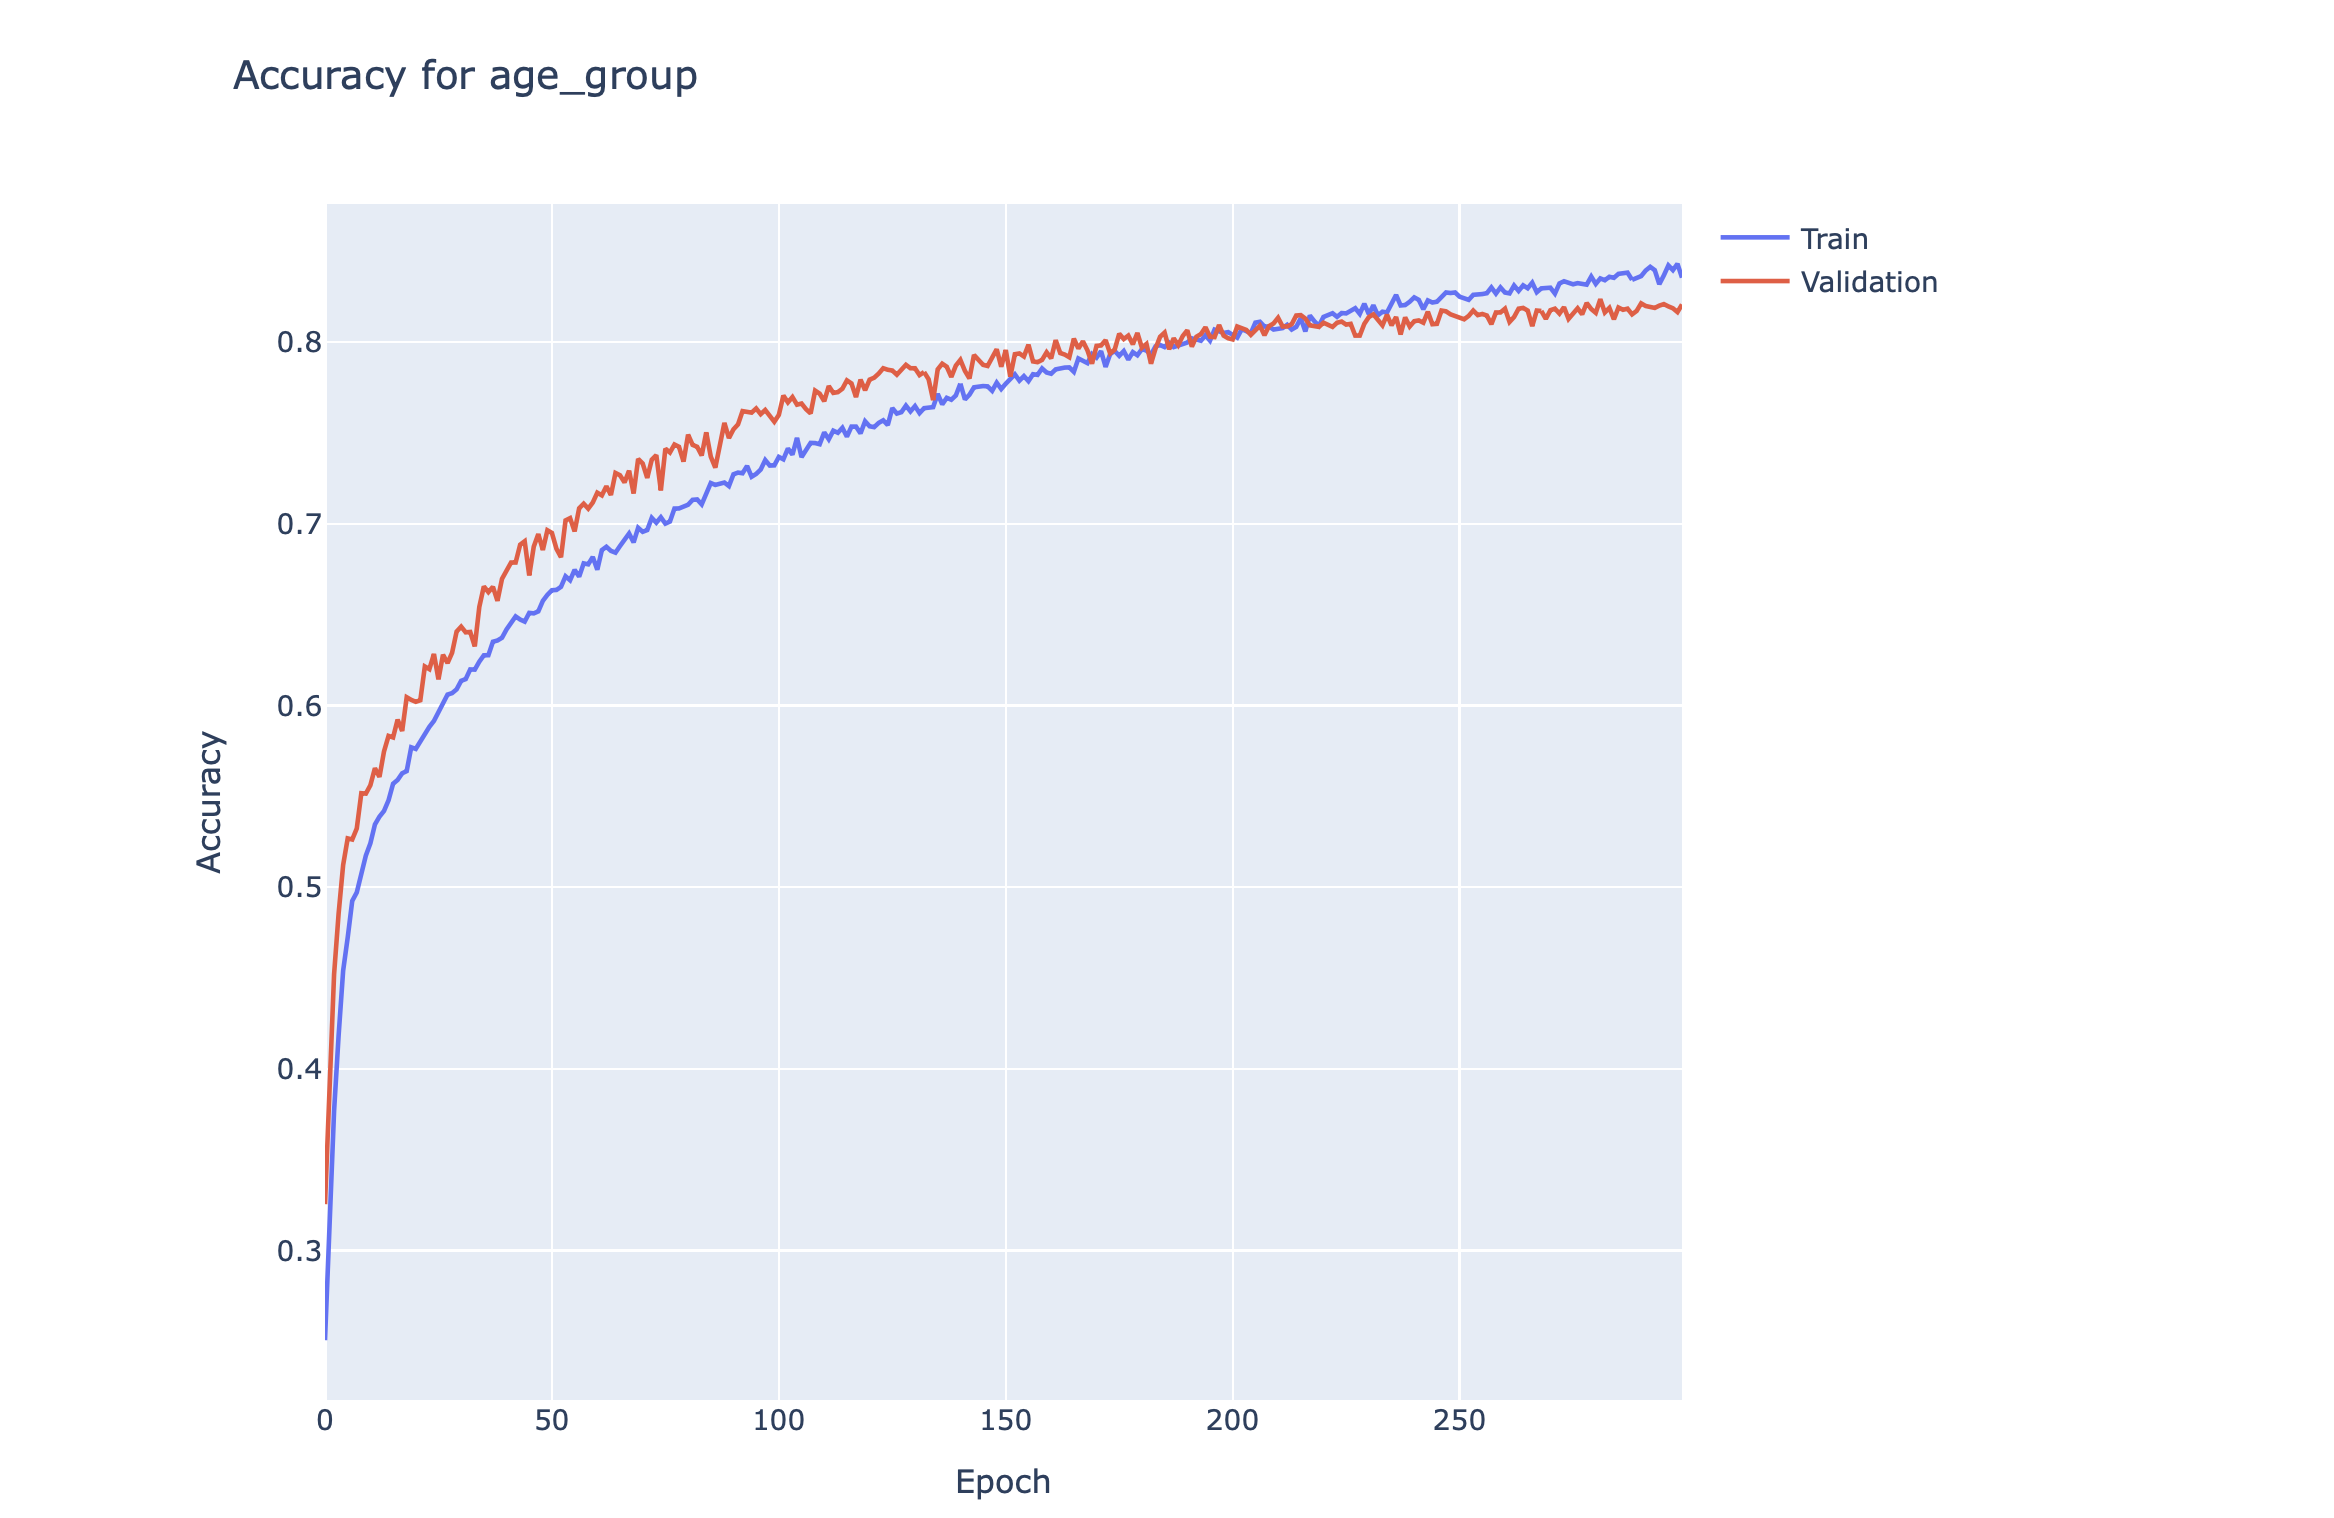

In [593]:
plot_metrics(title='Accuracy for sex', ylabel='Accuracy',
             metric=['sex_output_accuracy','val_sex_output_accuracy'])

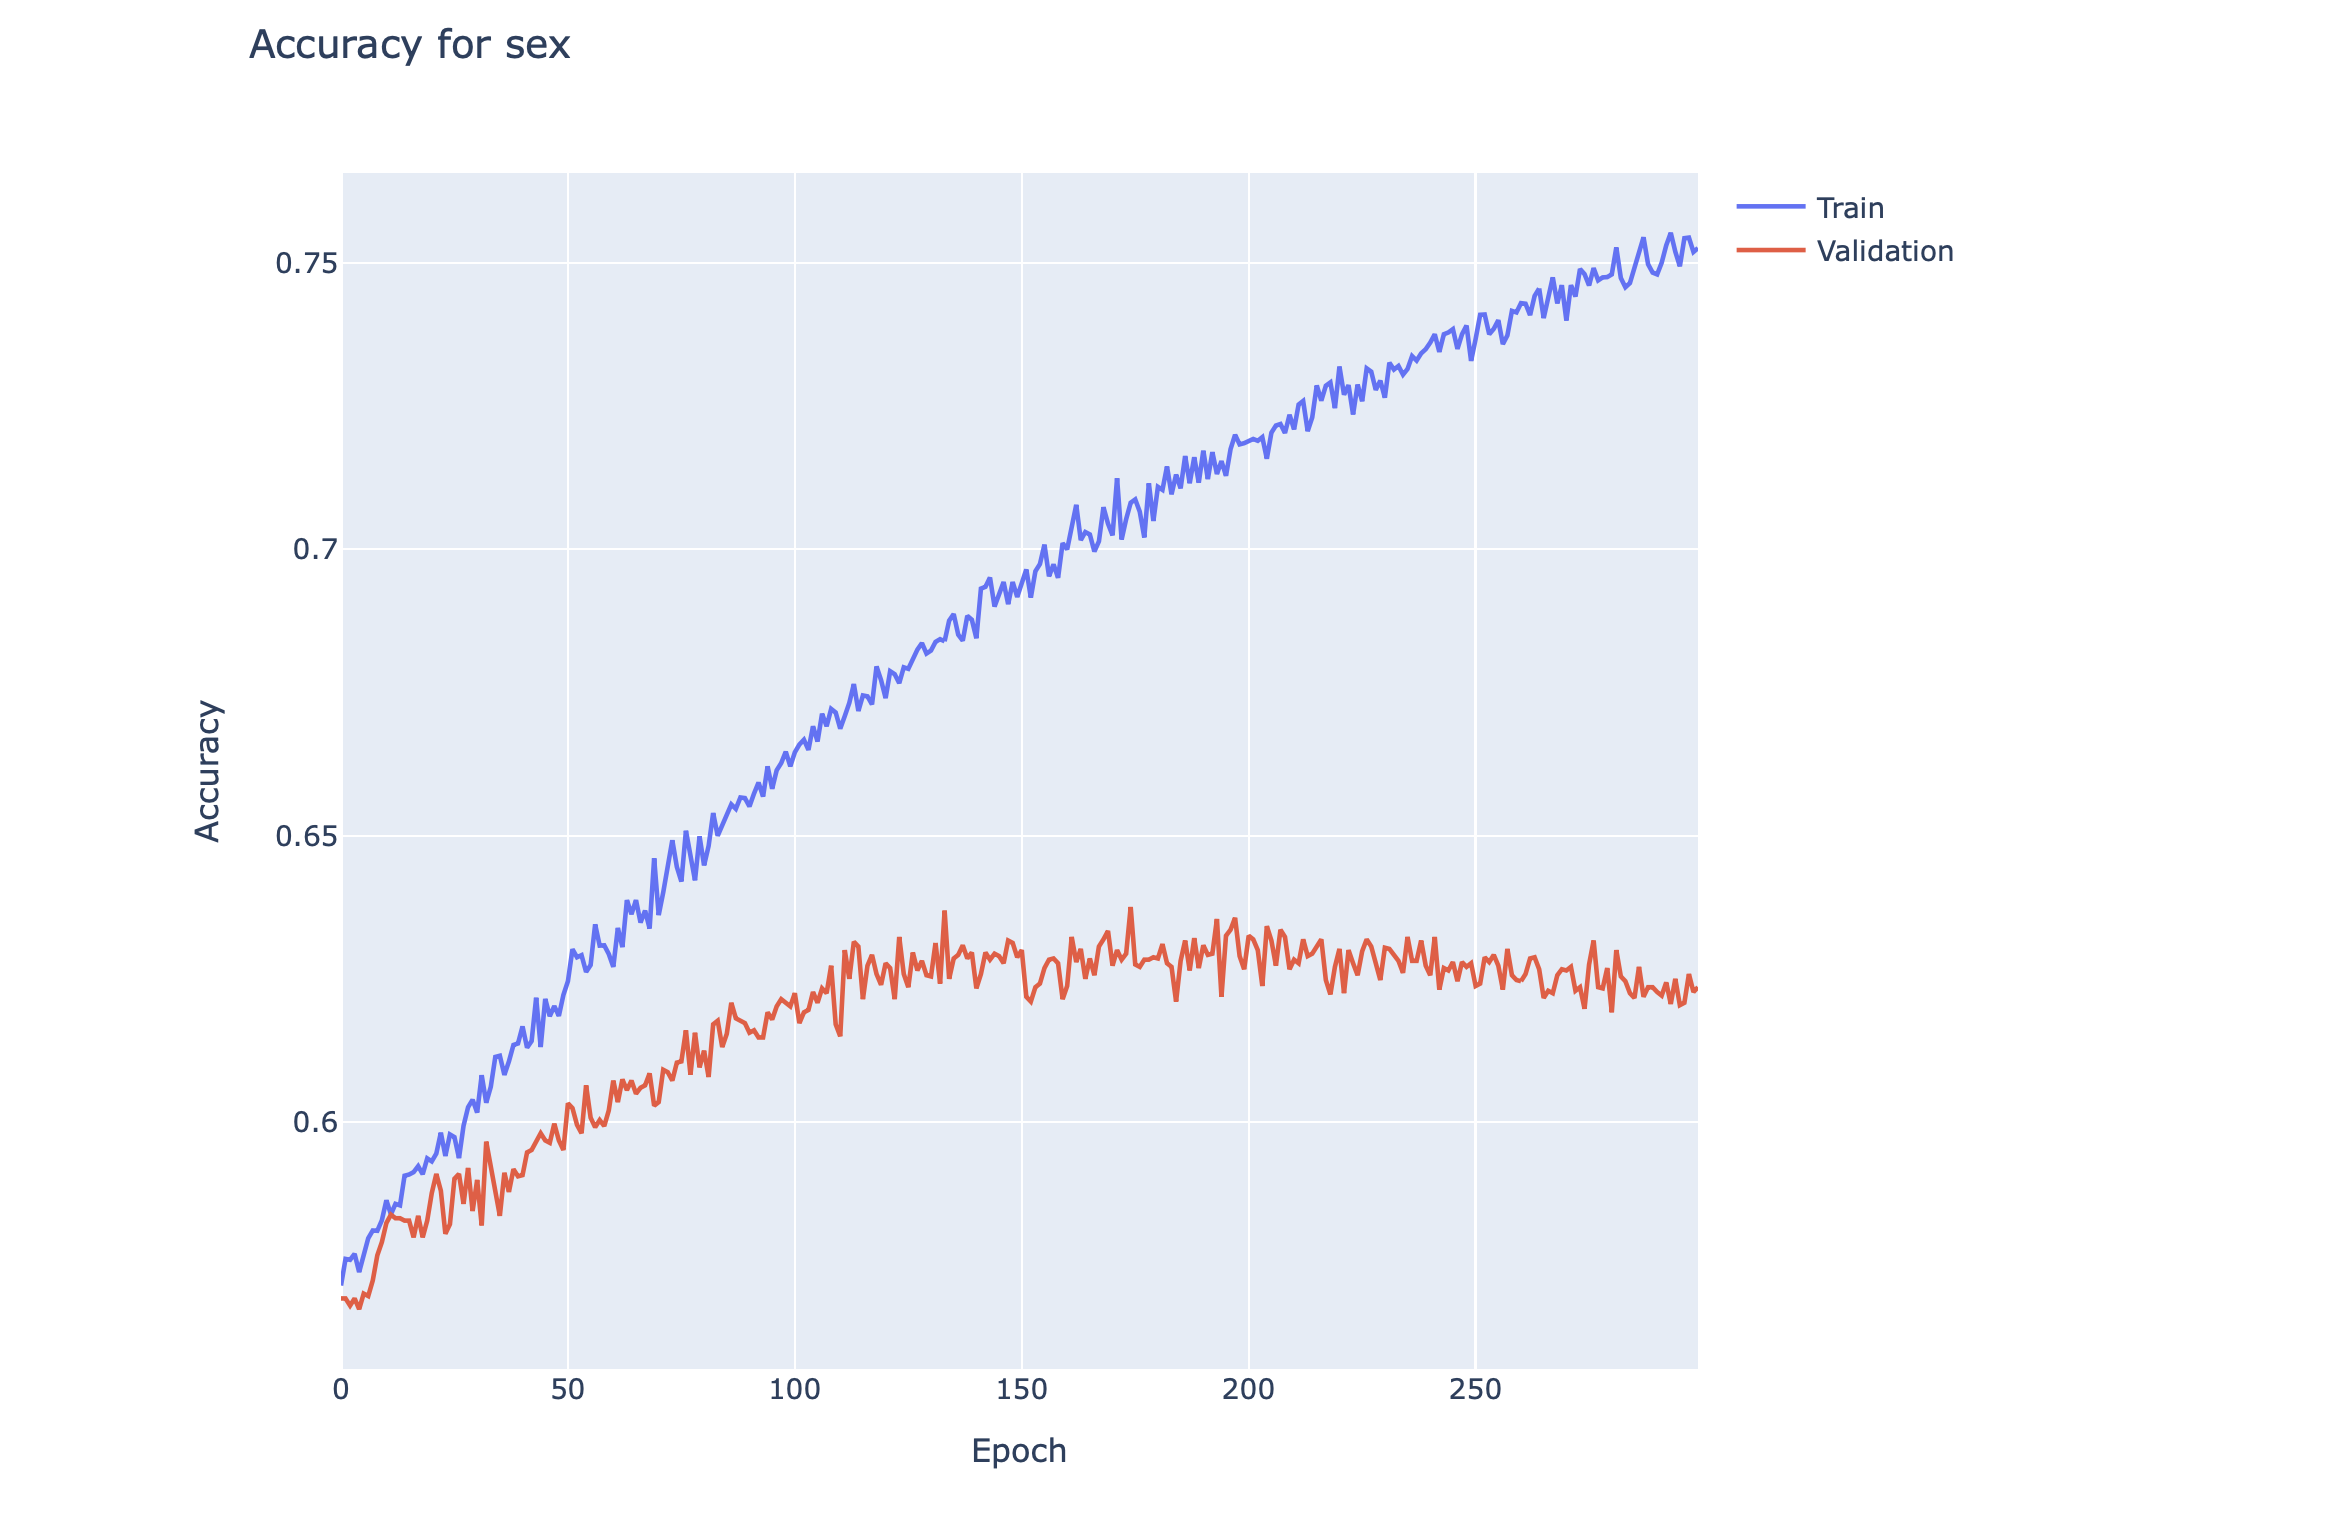

In [595]:
plot_metrics(title='MAE for boneage', ylabel='MAE',
             metric=['boneage_output_mae','val_boneage_output_mae'])

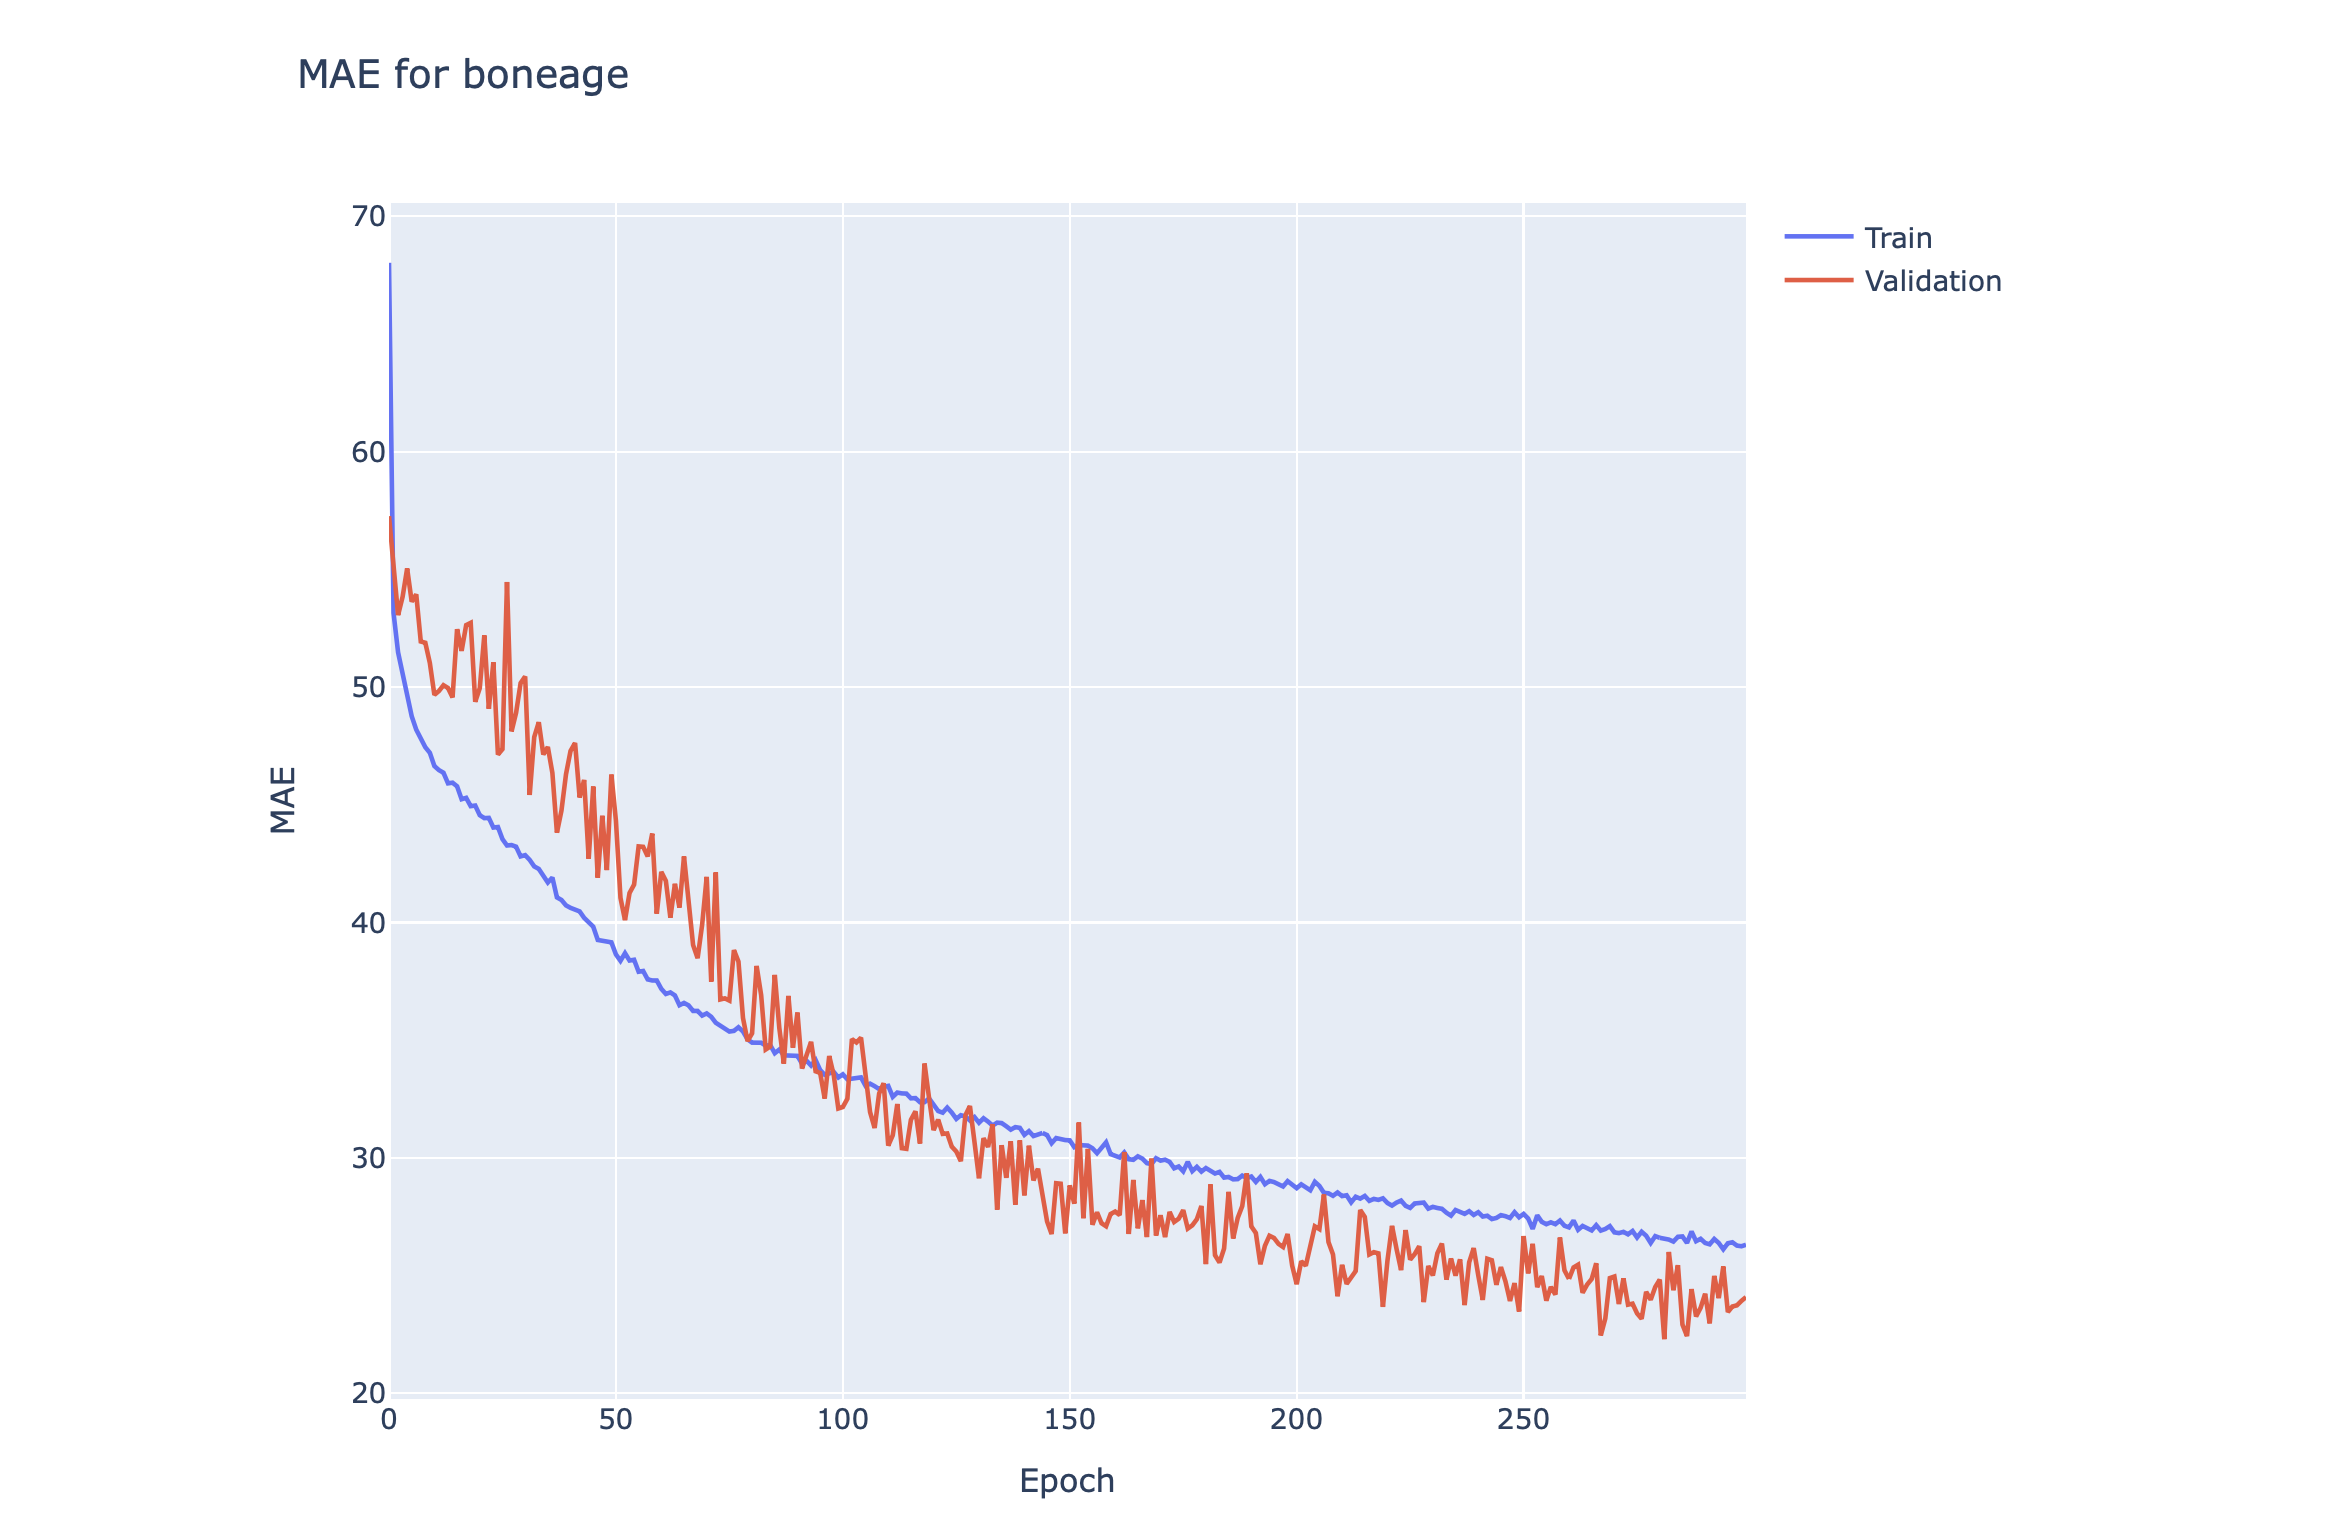

In [594]:
plot_metrics(title='Overall loss',ylabel='Loss',metric=['loss','val_loss'])

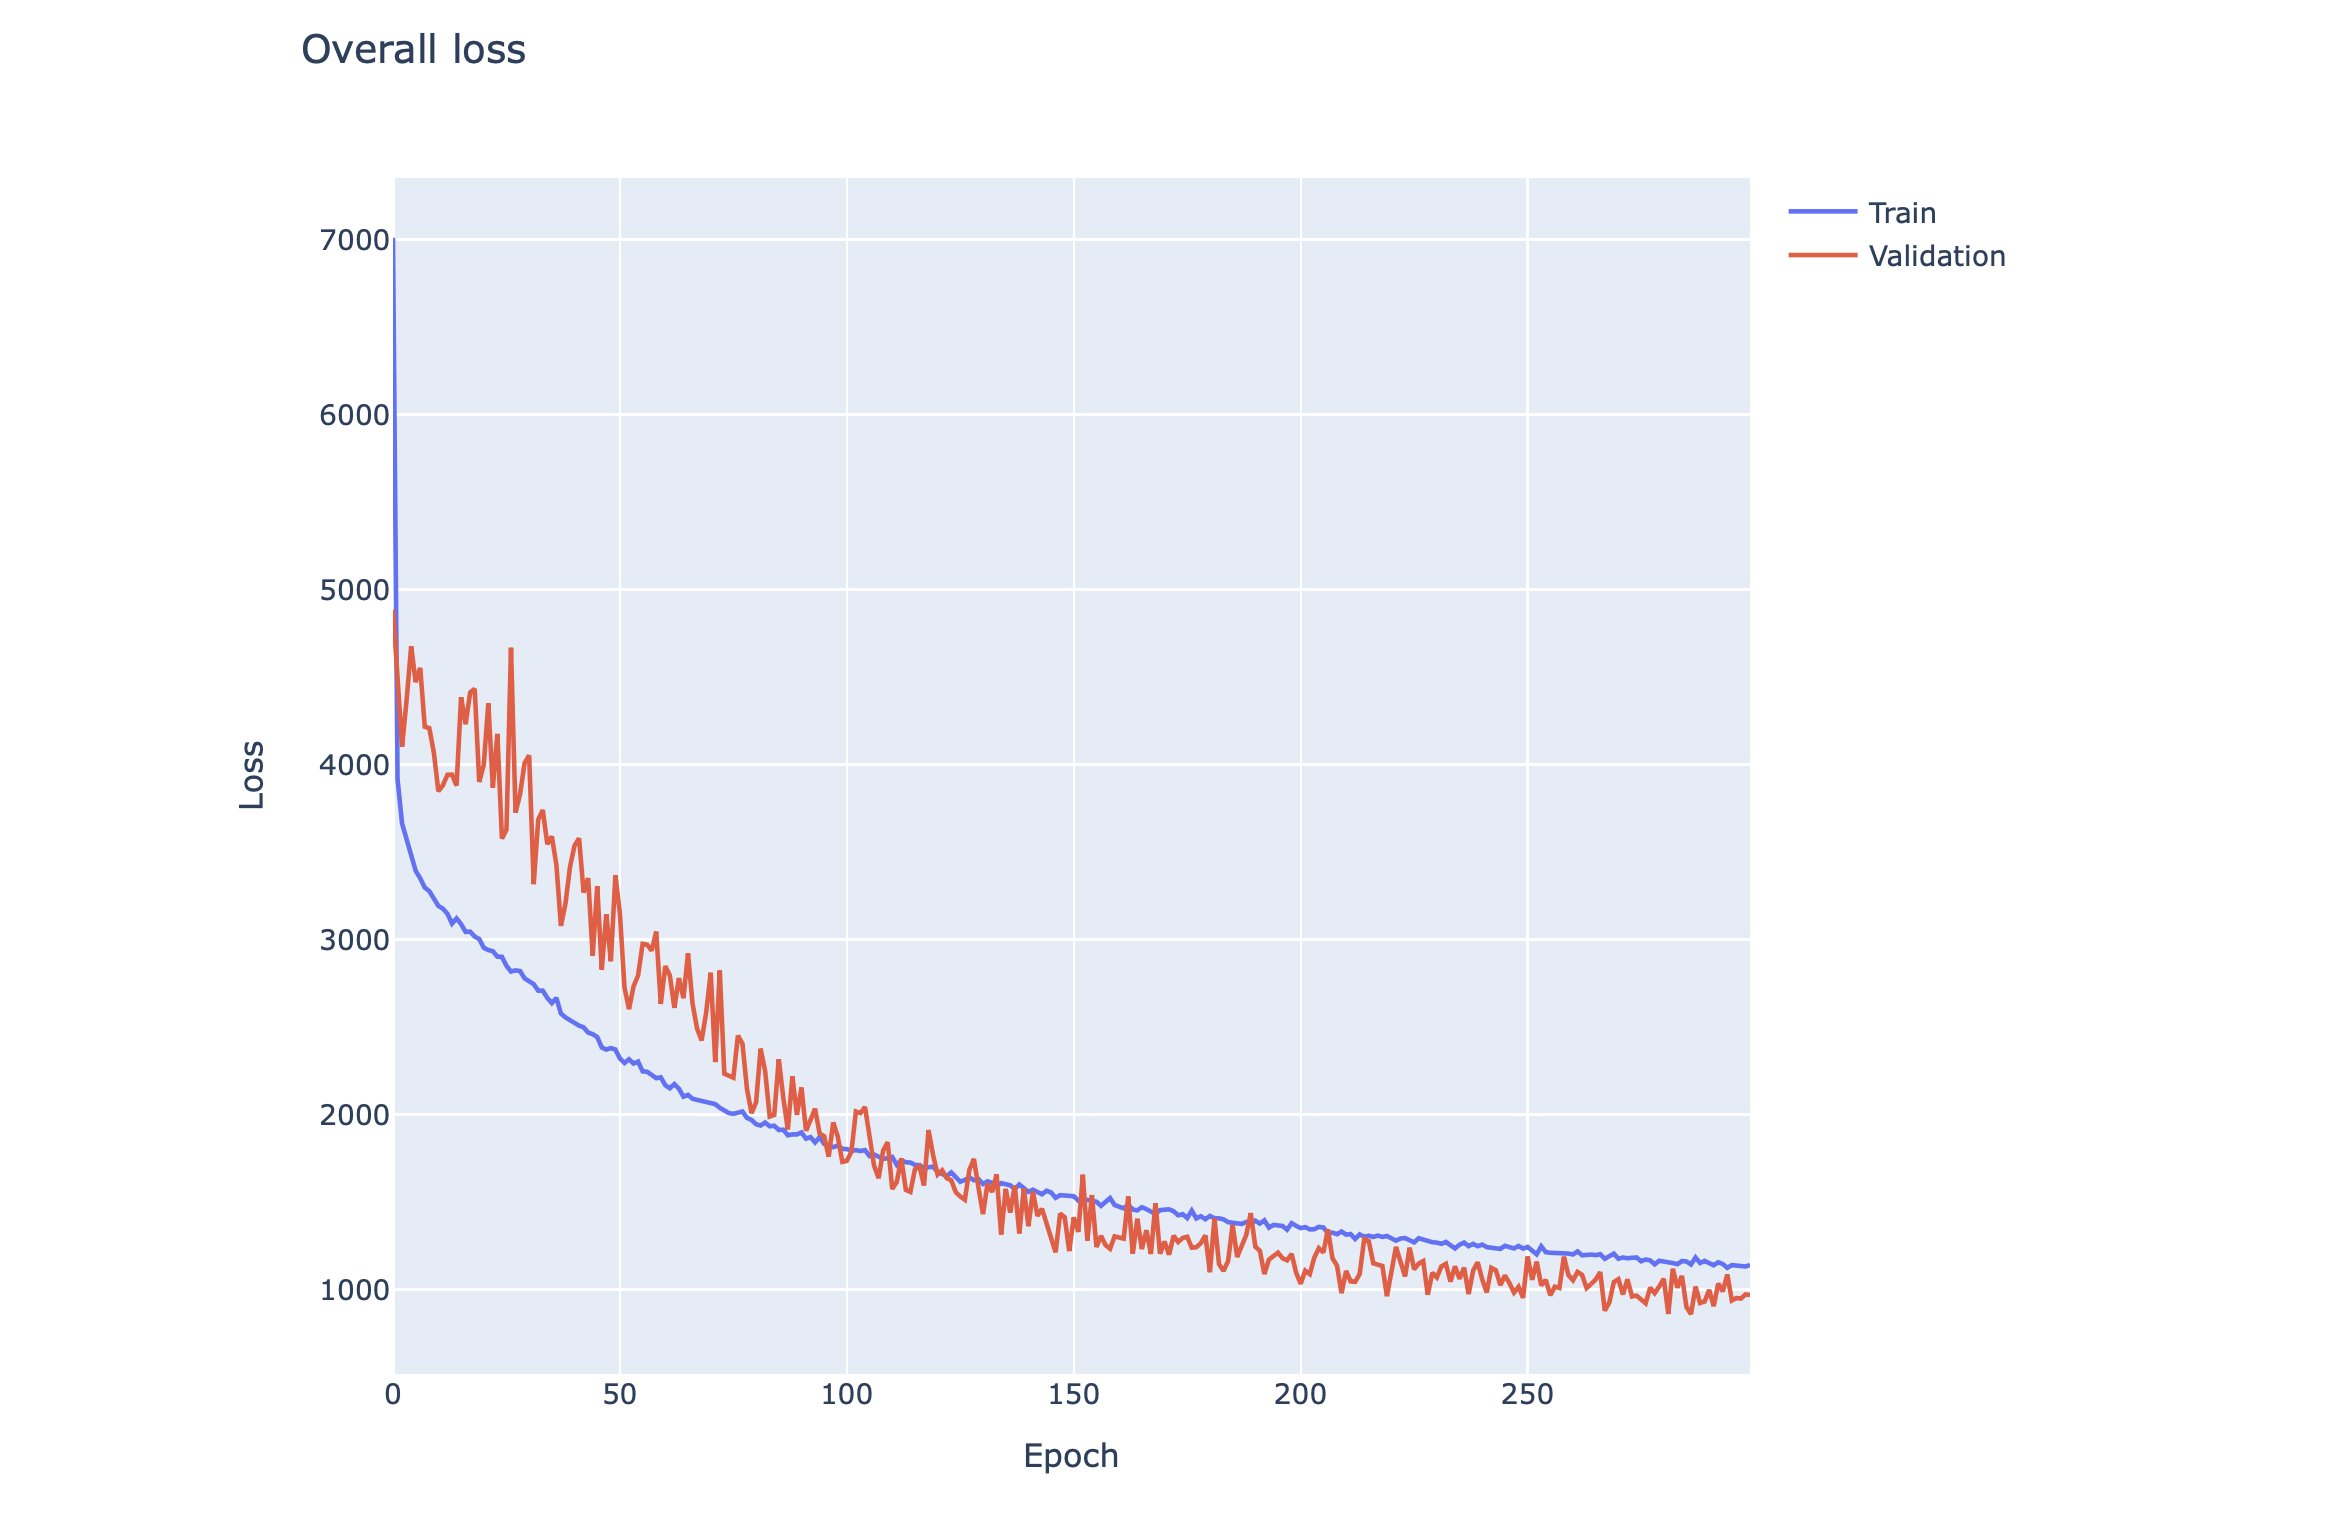

### model evaluation

In [147]:
model.evaluate(test_aug_images, test)#Xtest, validation

85/85 [==============================] - 3s 36ms/step - loss: 1285.6426 - boneage_output_loss: 1283.7301 - age_group_output_loss: 1.2499 - sex_output_loss: 0.6625 - boneage_output_mae: 28.2902 - age_group_output_accuracy: 0.6107 - sex_output_accuracy: 0.6381


[1285.642578125,
 1283.7301025390625,
 1.249923825263977,
 0.6624719500541687,
 28.29022216796875,
 0.6107407212257385,
 0.6381481289863586]

### predictions

In [148]:
boneage_true, age_group_true, sex_true  = test
boneage_pred, age_group_pred, sex_pred  = model.predict(test_aug_images)

In [153]:
def plot_age_regr(boneage_true, boneage_pred):
    
    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(boneage_true, boneage_pred, label='Model')
    ax.plot([boneage_true.min(), boneage_true.max()],[boneage_true.min(),boneage_true.max()],
           'r--', lw=4, label='Baseline')
    ax.set_xlabel('True boneage')
    ax.set_ylabel('Predicted Age')
    plt.legend(loc='best')
    plt.show()

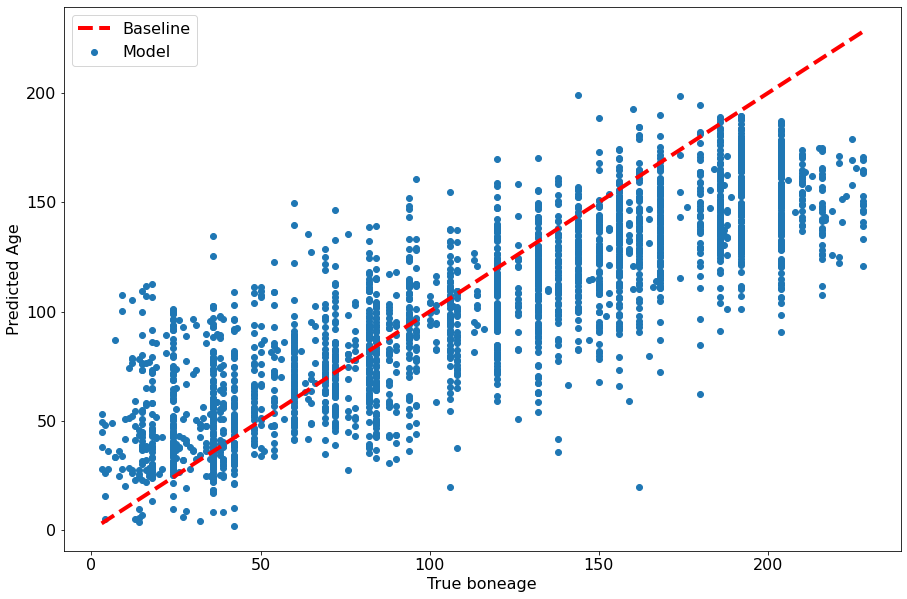

In [154]:
plot_age_regr(boneage_true, boneage_pred)

In [156]:
sex_pred = np.round(sex_pred)[:,0]
age_group_pred = age_group_pred.argmax(axis=-1)

### report 

In [157]:
print(set(age_group_pred))

{0, 1, 2, 3, 4}


In [158]:
cr_age_group = classification_report(val_labls[:,1], age_group_pred)
print(cr_age_group)

              precision    recall  f1-score   support

           0       0.85      0.54      0.66       540
           1       0.58      0.66      0.62       540
           2       0.53      0.62      0.57       540
           3       0.50      0.76      0.61       540
           4       0.85      0.48      0.61       540

    accuracy                           0.61      2700
   macro avg       0.66      0.61      0.61      2700
weighted avg       0.66      0.61      0.61      2700



In [159]:
cr_sex = classification_report(val_labls[:,2], sex_pred)
print(cr_sex)

              precision    recall  f1-score   support

           0       0.69      0.72      0.71      1628
           1       0.55      0.51      0.53      1072

    accuracy                           0.64      2700
   macro avg       0.62      0.62      0.62      2700
weighted avg       0.63      0.64      0.64      2700



####  confusion matrix

In [160]:
age_group_conf_matrix =  confusion_matrix(val_labls[:,1], age_group_pred)
gender_conf_matrix  = confusion_matrix(val_labls[:,2], sex_pred)

In [638]:
def show_heatmap_sex(conf_matrx, string):
    
    plt.figure(figsize=(15,8))
    sns.heatmap(conf_matrx/np.sum(conf_matrx), annot=True, cmap='Pastel2', fmt='.002%')
    plt.title(string+' Confusion Matrix')
    plt.show()

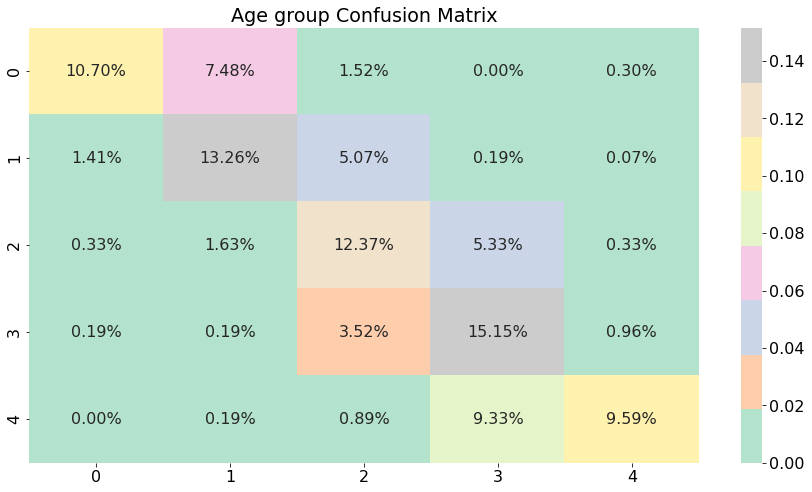

In [639]:
show_heatmap_sex(age_group_conf_matrix,'Age group')

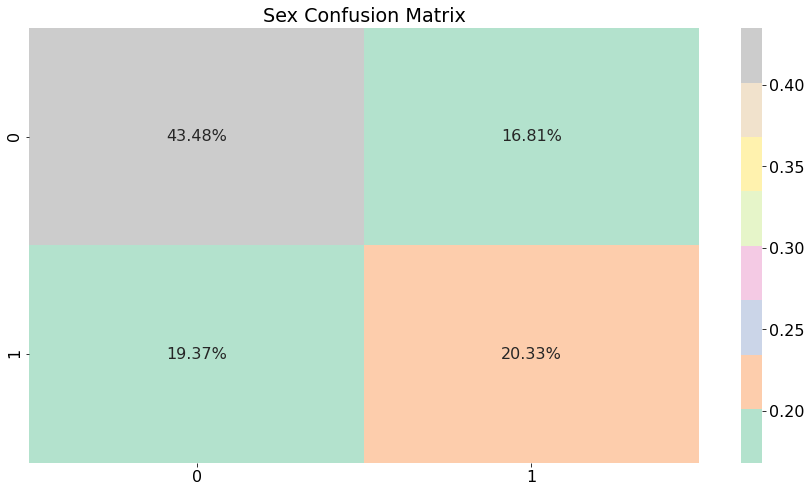

In [635]:
show_heatmap_sex(gender_conf_matrix, 'Sex')

#### test the results

In [167]:
def test_results(idx, images, images_norm, model):
    
    plt.imshow(images[idx])
    test_image  = images_norm[idx]
    test_boneage_pred, test_age_group_pred, test_sex_pred  = model.predict(np.array([test_image]))
    gen = ['Male', 'Female']
    test_boneage_pred = int(np.round(test_boneage_pred)[0,0]) 
    test_sex_pred = int(np.round(test_sex_pred)[0,0])
    print(f"predicted [Age: {str(test_boneage_pred)}, Sex: {gen[test_sex_pred]}]")

predicted [Age: 90, Sex: Female]


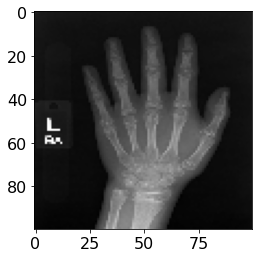

In [168]:
test_results(808, val_images, val_images_norm, model)

In [658]:
def print_random_examples(images, images_norm, model):
    """
    Randomly  generates test images and print the corresponding info
    """
    import random
    idx = random.choice([x for x in range(len(images))])
    #print(idx)
    plt.figure(figsize=(10,10))
    plt.imshow(images[idx])
    actual_age = val_age_list[idx]
    actual_group = val_age_group_list[idx]
    actual_gender = val_gender_list[idx]
    test_image  = val_images_norm[idx] 
    test_boneage_pred, test_age_group_pred, test_sex_pred  = model.predict(np.array([test_image]))
    gen = ['Male', 'Female']
    group = ['<46','[46, 92]','[92, 138]','[138-184]','184+']
    test_boneage_pred = int(np.round(test_boneage_pred)[0,0]) 
    test_sex_pred = int(np.round(test_sex_pred)[0,0])
    test_age_group_pred = int(test_age_group_pred.argmax(axis=-1))
    print((f"Ground truth:[Age:{actual_age}, Age_group: {group[actual_group]}, Sex:{gen[actual_gender]}] \n"  
        f"**** predicted:[Age:{str(test_boneage_pred)}, Age_group: {group[test_age_group_pred]}, Sex:{gen[test_sex_pred]}]"))

Ground truth:[Age:72, Age_group: [46, 92], Sex:Male] 
**** predicted:[Age:69, Age_group: [46, 92], Sex:Male]


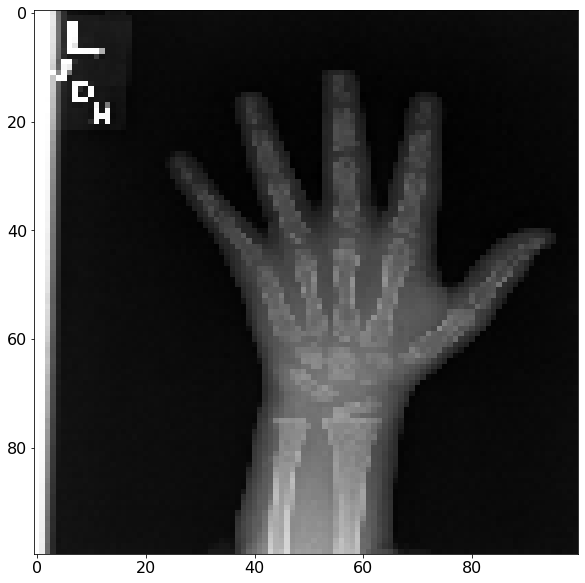

In [659]:
print_random_examples(val_images, val_images_norm, model)